<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Databehandling-Pradeep/Bioco_Databehandling_av_ekstremverdier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lasting av nødvendige pakker og bibliotek

In [ ]:
! pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.0-py3-none-any.whl size=196324 sha256=814420d53cebc3f671bc18532c37c9130c647c738e75976ddc965392b602111f
  Stored in directory: /root/.cache/pip/wheels/15/0e/91/96b270e6741d4eece88727489411330226ff47ac1cb9ea0097
Successfully built pyod


Importering av nødvendige pakker og bibliotek

In [ ]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


from pyod.models.cblof import CBLOF
from pyod.models.lof import LOF

Importering av data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
behandlet_data = pd.read_csv('/content/drive/MyDrive/MasterV24/Bioco_data/manglende_data_behandlet_bioco_data.csv',
                             header=0,
                             sep=',',
                             index_col=0)

# Importerer rådata
rå_data = pd.read_csv('/content/drive/MyDrive/MasterV24/BiocoData.csv',
                      header=0,
                      sep=';',
                      index_col=0)

# Formatterer index til riktig format og datatype
behandlet_data.index = pd.to_datetime(behandlet_data.index,
                                      format='%Y-%m-%d %H:%M:%S')

rå_data.index = pd.to_datetime(rå_data.index,
                               format='%d-%m-%Y %H:%M:%S.%f')

Mounted at /content/drive


In [ ]:
random_seed = 2024

# Funksjoner

##  For plotting av violin plot med bestemte aksegrenser

In [ ]:
def plot_violin_grid(data, min_max_dict=None, fig_size=(15, 20)):

    fig = plt.figure(figsize=fig_size)
    antall_kolonnner = len(data.columns)
    rute_nett = fig.add_gridspec(8, 3)

    n = 0
    for nummer, indeks in zip(range(antall_kolonnner), data):
        if nummer % 3 == 0:
            n += 1
            i = 0
        ax = fig.add_subplot(rute_nett[n, i])
        sns.violinplot(x=indeks, data=data)
        sns.rugplot(x=data[indeks])

        # Bruker min_max_dict for x-akse grenser

        if (min_max_dict is not None) and (indeks in min_max_dict):
            min_val, max_val = min_max_dict[indeks]
            ax.set_xlim(min_val, max_val)

        ax.set_xticks([])
        ax.set_xlabel(indeks)
        i += 1

    plt.tight_layout()
    plt.show()

Plott av scores for ekstremverdier

In [ ]:
def plot_ekstrem_score(y_scores,  modell, figsize=(15,10)):
  fig, axs = plt.subplots(1, 2, figsize=figsize)

  plt.subplot(2,2,1)
  sns.scatterplot(data=y_scores)
  plt.xlabel('Observasjon')
  plt.ylabel('Score')
  plt.title(f"Inspeksjon av ekstremverdier med {modell}")

  plt.subplot(2,2,2)
  plt.plot(list(y_scores))
  plt.xlabel('Observasjon')
  plt.ylabel('Score')
  plt.title(f"Inspeksjon av ekstremverdier med {modell}")

  plt.show()

In [ ]:
def plot_ekstrem_score(y_scores, yscore, modell, figsize=(15,10)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)  # Create figure and axes first

    # Scatterplot on the first subplot
    sns.scatterplot(data=y_scores, ax=axs[0])  # Use ax=axs[0] to specify the subplot
    axs[0].set_xlabel('Observasjon')  # Set labels and title for the first subplot
    axs[0].set_ylabel('Score')
    axs[0].set_title(f"Inspeksjon av ekstremverdier med {modell}")

    # Line plot on the second subplot
    axs[1].plot(list(y_scores))  # Use ax=axs[1] to specify the subplot
    axs[1].set_xlabel('Observasjon')  # Set labels and title for the second subplot
    axs[1].set_ylabel('Score')
    axs[1].set_title(f"Inspeksjon av ekstremverdier med {modell}")

    for ax in axs:
        ax.axhline(yscore, color='red', linestyle='dashed', linewidth=1)

    plt.show()

## For oppdeling av data

In [ ]:
def splitt_design_normal(rå_data, data):
    """

    """

    # Finner informasjon om dag
    data_enzym = data.copy()

    enzym_data = rå_data.merge(data_enzym,
                             left_index=True,
                              right_index=True,
                              how='inner',
                              suffixes=('','_drop'))['EnzymeCode']

    data_enzym["EnzymeCode"] = enzym_data

    # Splitter data etter dagsinformasjon om produksjonstyper
    design_sett = data_enzym[data_enzym['EnzymeCode'] != "A2"].copy()
    normal_sett = data_enzym[data_enzym['EnzymeCode'] == "A2"].copy()

    # Ekskluderer variabel med dagsinfomasjon
    design_sett.drop(columns=['EnzymeCode'], inplace=True)
    normal_sett.drop(columns=['EnzymeCode'], inplace=True)

    return design_sett, normal_sett

In [ ]:
def splitt_markert_umarkert(data):
    """

    """

    # Splitter data etter dagsinformasjon om produksjonstyper
    markert_sett = data.dropna(subset=['Mw'])
    umarkert_sett = data[data['Mw'].isna()]

    return markert_sett, umarkert_sett

## Telle antall mulige ekstremverdier per kolonne

In [ ]:
def antall_ekstremverdier(data, kolonnenavn, faktor=1.5):
    """

    """

    # Beregn kvartiler og IQR
    Q1 = data[kolonnenavn].quantile(0.25)
    Q3 = data[kolonnenavn].quantile(0.75)
    IQR = Q3 - Q1

    # Beregn grensene for ekstremverdier
    nedre_grense = Q1 - faktor * IQR
    øvre_grense = Q3 + faktor * IQR

    # Identifiser ekstremverdier
    ekstrem_under = data[data[kolonnenavn] < nedre_grense]
    ekstrem_over = data[data[kolonnenavn] > øvre_grense]

    return len(ekstrem_under), len(ekstrem_over), (len(ekstrem_under) + len(ekstrem_over))


In [ ]:
def finn_beste_faktor_ekstrem_verdier_totalt(data, start_faktor, slutt_faktor, kolonner):
    """
    Denne funksjonen finner faktoren (innenfor et intervall) som gir den største endringen i totalt antall UNIIKE ekstrem_verdier på tvers av flere kolonner, og returnerer også det totale antallet UNIIKE ekstrem_verdier for denne faktoren.

    Args:
        data (pd.DataFrame): Datasettetet som inneholder kolonnene som skal analyseres.
        start_faktor (float): Startverdien for faktorintervallet.
        slutt_faktor (float): Sluttverdien for faktorintervallet.
        kolonner (list): En liste med kolonnenavn som skal analyseres.

    Returns:
        tuple: Et tuppel som inneholder (beste_faktor, antall_unike_ekstremverdier)
    """

    beste_faktor = None
    ekstrem_verdier_beste_faktor = set()
    største_endring = 0
    ekstrem_verdier_forrige = {}  # Bruk en dictionary i stedet for et set

    for faktor in np.arange(start_faktor, slutt_faktor + 0.1, 0.1):
        ekstrem_verdier_nåværende = {}

        for kolonne in kolonner:
            Q1 = data[kolonne].quantile(0.25)
            Q3 = data[kolonne].quantile(0.75)
            IQR = Q3 - Q1

            nedre_grense = Q1 - faktor * IQR
            øvre_grense = Q3 + faktor * IQR

            # Get indices of extreme values for this column and factor
            ekstreme_indekser = data[(data[kolonne] < nedre_grense) | (data[kolonne] > øvre_grense)].index

            for idx in ekstreme_indekser:
                if idx in ekstrem_verdier_nåværende:
                    ekstrem_verdier_nåværende[idx].add(kolonne)
                else:
                    ekstrem_verdier_nåværende[idx] = {kolonne}

        endring = (len(ekstrem_verdier_forrige) - len(ekstrem_verdier_nåværende))

        if (endring > største_endring) and (faktor != start_faktor):
            største_endring = endring
            beste_faktor = faktor
            ekstrem_verdier_beste_faktor = (ekstrem_verdier_nåværende)
            antall_ekstrem_best = len(ekstrem_verdier_beste_faktor)


        ekstrem_verdier_forrige = ekstrem_verdier_nåværende.copy()

    return beste_faktor, ekstrem_verdier_beste_faktor, antall_ekstrem_best

## Informasjon om kategoriske variabler

In [ ]:
def kategorier_per_variabel(rå_data, data, var1_name, var2_name):
    """

    """

    # Prepare enzyme and material data
    enzym_data = rå_data.merge(data,
                               left_index=True,
                               right_index=True,
                               how='inner',
                               suffixes=('','_drop'))['EnzymeCode']

    material_data = rå_data.merge(data,
                                  left_index=True,
                                  right_index=True,
                                  how='inner',
                                  suffixes=('','_drop'))['RawMaterialMix']


    data_enzym_materiale = data.join(enzym_data).join(material_data)


    resultat = (
        data_enzym_materiale.groupby(var1_name)[var2_name]
        .nunique()
        .reset_index()
    )

    antall_kombinasjoner = resultat["RawMaterialMix"].sum()

    return antall_kombinasjoner

In [ ]:
def kategoriske_fordelinger(data):


  """

  """
    # Prepare enzyme and material data
  enzym_data = rå_data.merge(data,
                              left_index=True,
                              right_index=True,
                              how='inner',
                              suffixes=('','_drop'))['EnzymeCode']

  material_data = rå_data.merge(data,
                                left_index=True,
                                right_index=True,
                                how='inner',
                                suffixes=('','_drop'))['RawMaterialMix']


  data_enzym_materiale = data.join(enzym_data).join(material_data)



  # Sjekker krav til kategorier
  kategoriske_variabler = ['EnzymeCode', 'RawMaterialMix']
  for col in kategoriske_variabler:
    if col not in data_enzym_materiale.columns:
      raise ValueError(f"Mangler '{col}' i data.")

  fordelinger = {}

  # Berenger frekvens aog andeler
  for col in kategoriske_variabler:

    frekvens = data_enzym_materiale[col].value_counts()
    andel = data_enzym_materiale[col].value_counts(normalize=True) * 100

    fordelings_data = pd.DataFrame({
        'Frekvens': frekvens,
        'Andel (%)': andel
    })

    fordelinger[col] = fordelings_data

  # Printer resultater
  for col, data in fordelinger.items():
    print(f"\n**Fordelingen i '{col}':**")
    print(data.to_markdown(numalign='left', stralign='left'))

# Undersøkelse av data før behandling for ekstreme verdier

In [ ]:
behandlet_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29136 non-null  int64  
 1   EnzymeType_A2   29136 non-null  int64  
 2   EnzymeType_B    29136 non-null  int64  
 3   EnzymeType_C    29136 non-null  int64  
 4   EnzymeType_D    29136 non-null  int64  
 5   EnzymeType_E    29136 non-null  int64  
 6   RawMatPercent   29136 non-null  float64
 7   NIRfat          29136 non-null  float64
 8   NIRash          29136 non-null  float64
 9   NIRwater        29136 non-null  float64
 10  TT08            29136 non-null  float64
 11  TT20            29136 non-null  float64
 12  TT12            29136 non-null  float64
 13  Collagen        89 non-null     float64
 14  Mw              460 non-null    float64
 15  SmallMolecules  460 non-null    float64
 16  BrixAdjusted    460 non-null    float64
d

# Inspeksjon av mulige ekstremverdier

Henter prediktorer verdiene som skal undersøkes

In [ ]:
# Utelukker data fra kategoriske variabler for inspeksjon
prediktor_data = behandlet_data.iloc[:, :-4]

# Henter ut kun verdier for undersøkelse
X = prediktor_data.values

# lager en dictionary med min og maks verdier for variabel
# for å definere fast skala ved visualiseringer
min_max_dict = {}
for col in prediktor_data.columns:
  min_max_dict[col] = [prediktor_data[col].min(), prediktor_data[col].max()]

## Violin plot

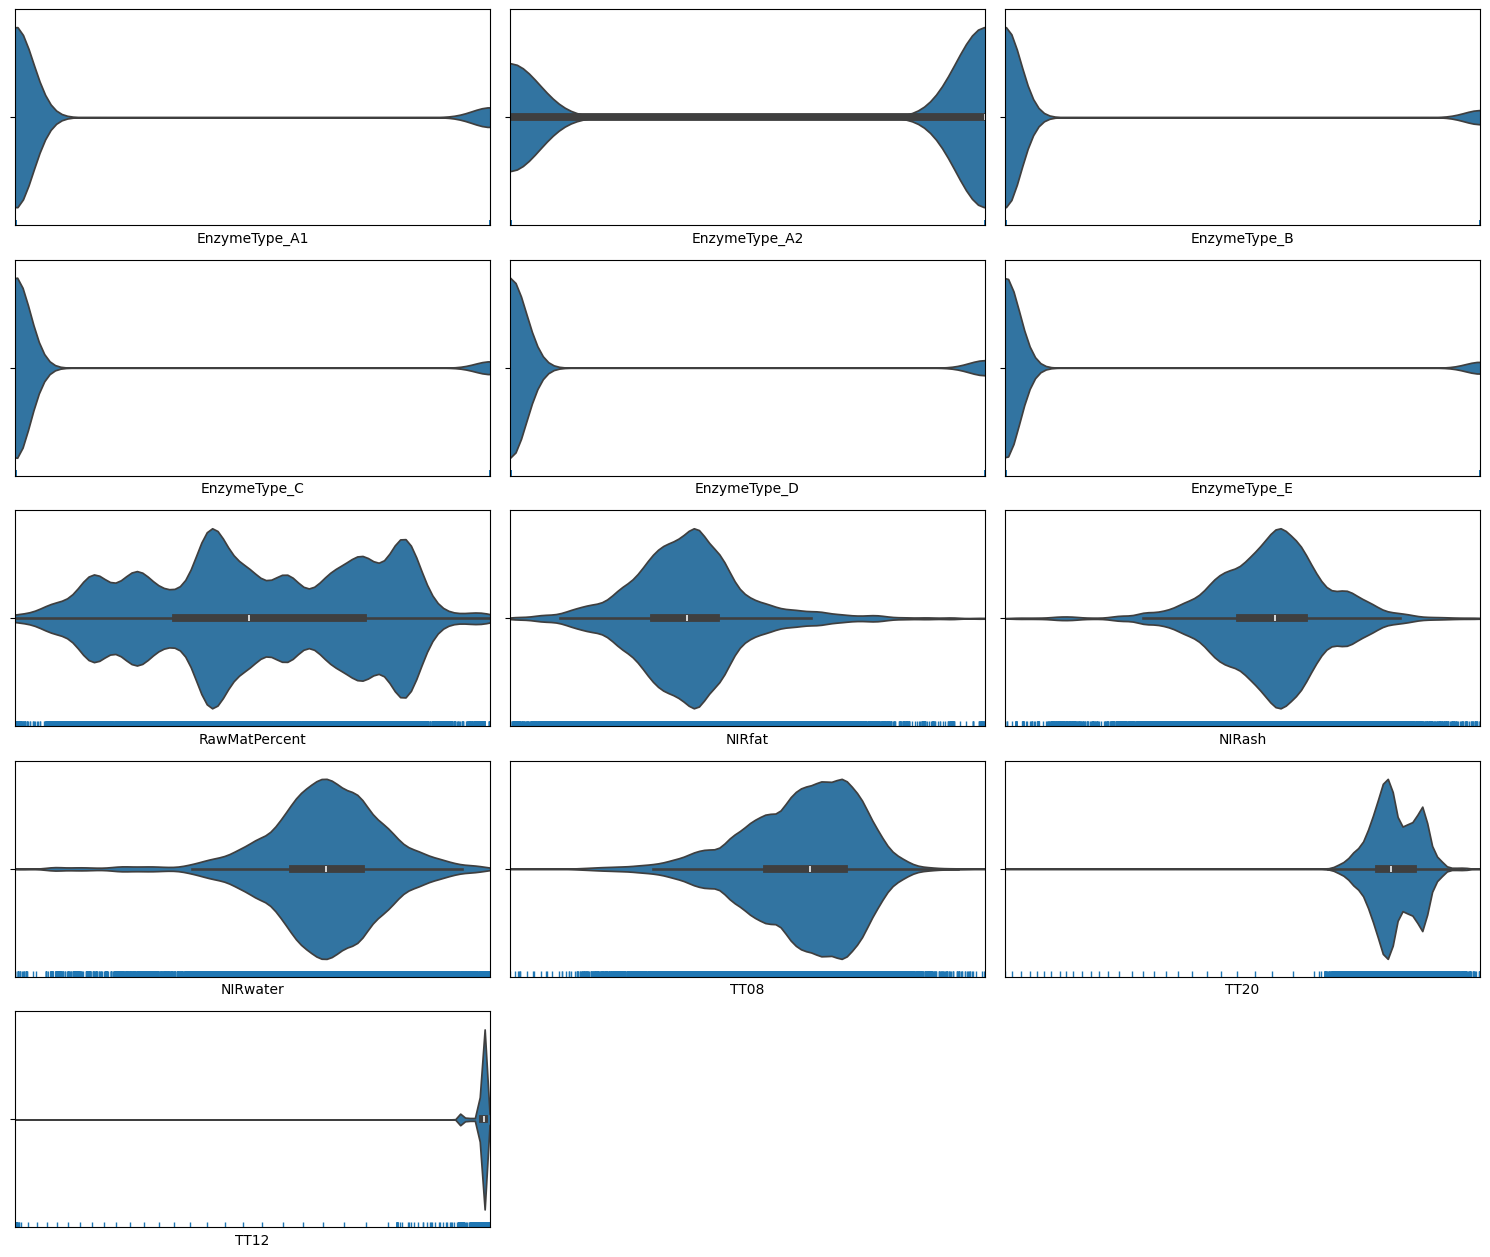

In [ ]:
# Violin plot av data for behandling og inspeksjon
plot_violin_grid(prediktor_data, min_max_dict, fig_size=(15, 20))

# Deler datasettet i design og normal del for inspeksjon

In [ ]:
# Splitter data i design og normal sett
data_design, data_normal = splitt_design_normal(rå_data, behandlet_data)

# Design
prediktor_design = data_design.iloc[:, :-4]
X_design= prediktor_design.values

min_max_dict_design = {}
for col in prediktor_design.columns:
  min_max_dict_design[col] = [prediktor_design[col].min(), prediktor_design[col].max()]

# Normal
prediktor_normal = data_normal.iloc[:, :-4]
X_normal = prediktor_normal.values

min_max_dict_normal = {}
for col in prediktor_normal.columns:
  min_max_dict_normal[col] = [prediktor_normal[col].min(), prediktor_normal[col].max()]

### Inspeksjon av design data

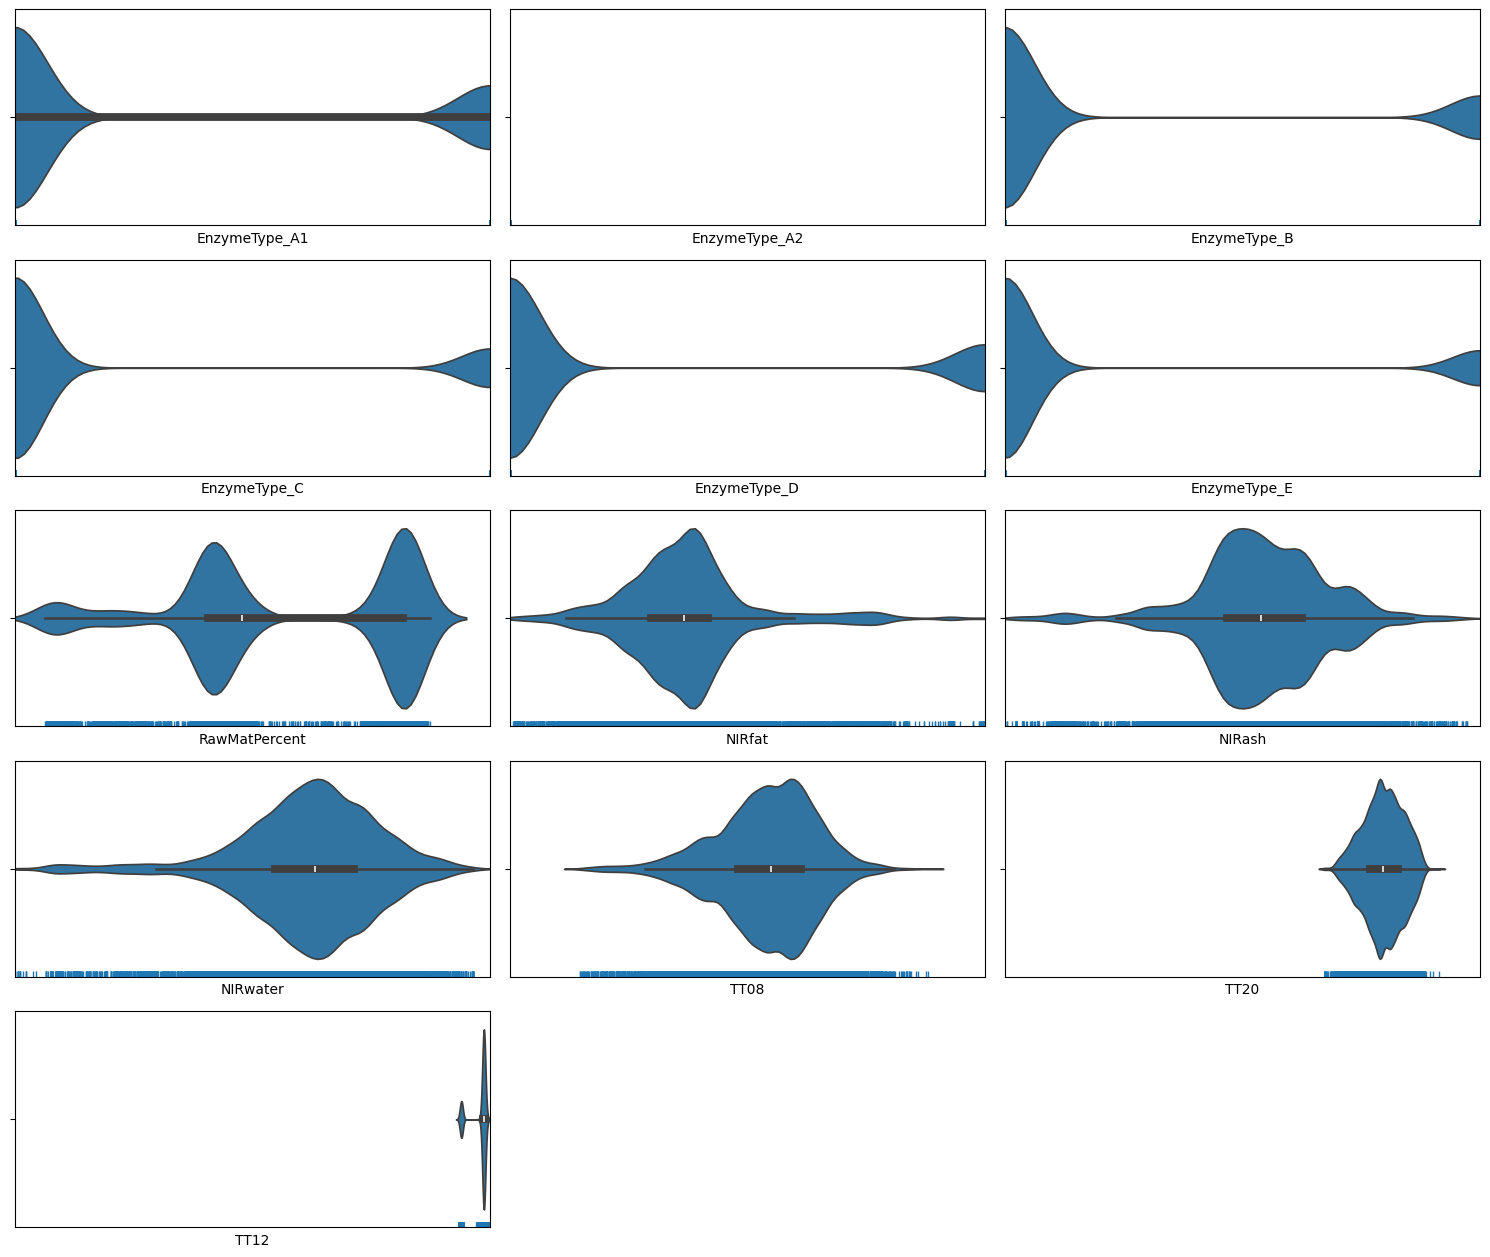

In [ ]:
# Violin plot av data for behandling og inspeksjon
plot_violin_grid(prediktor_design, min_max_dict, fig_size=(15, 20))

###Inspeksjon av normal data

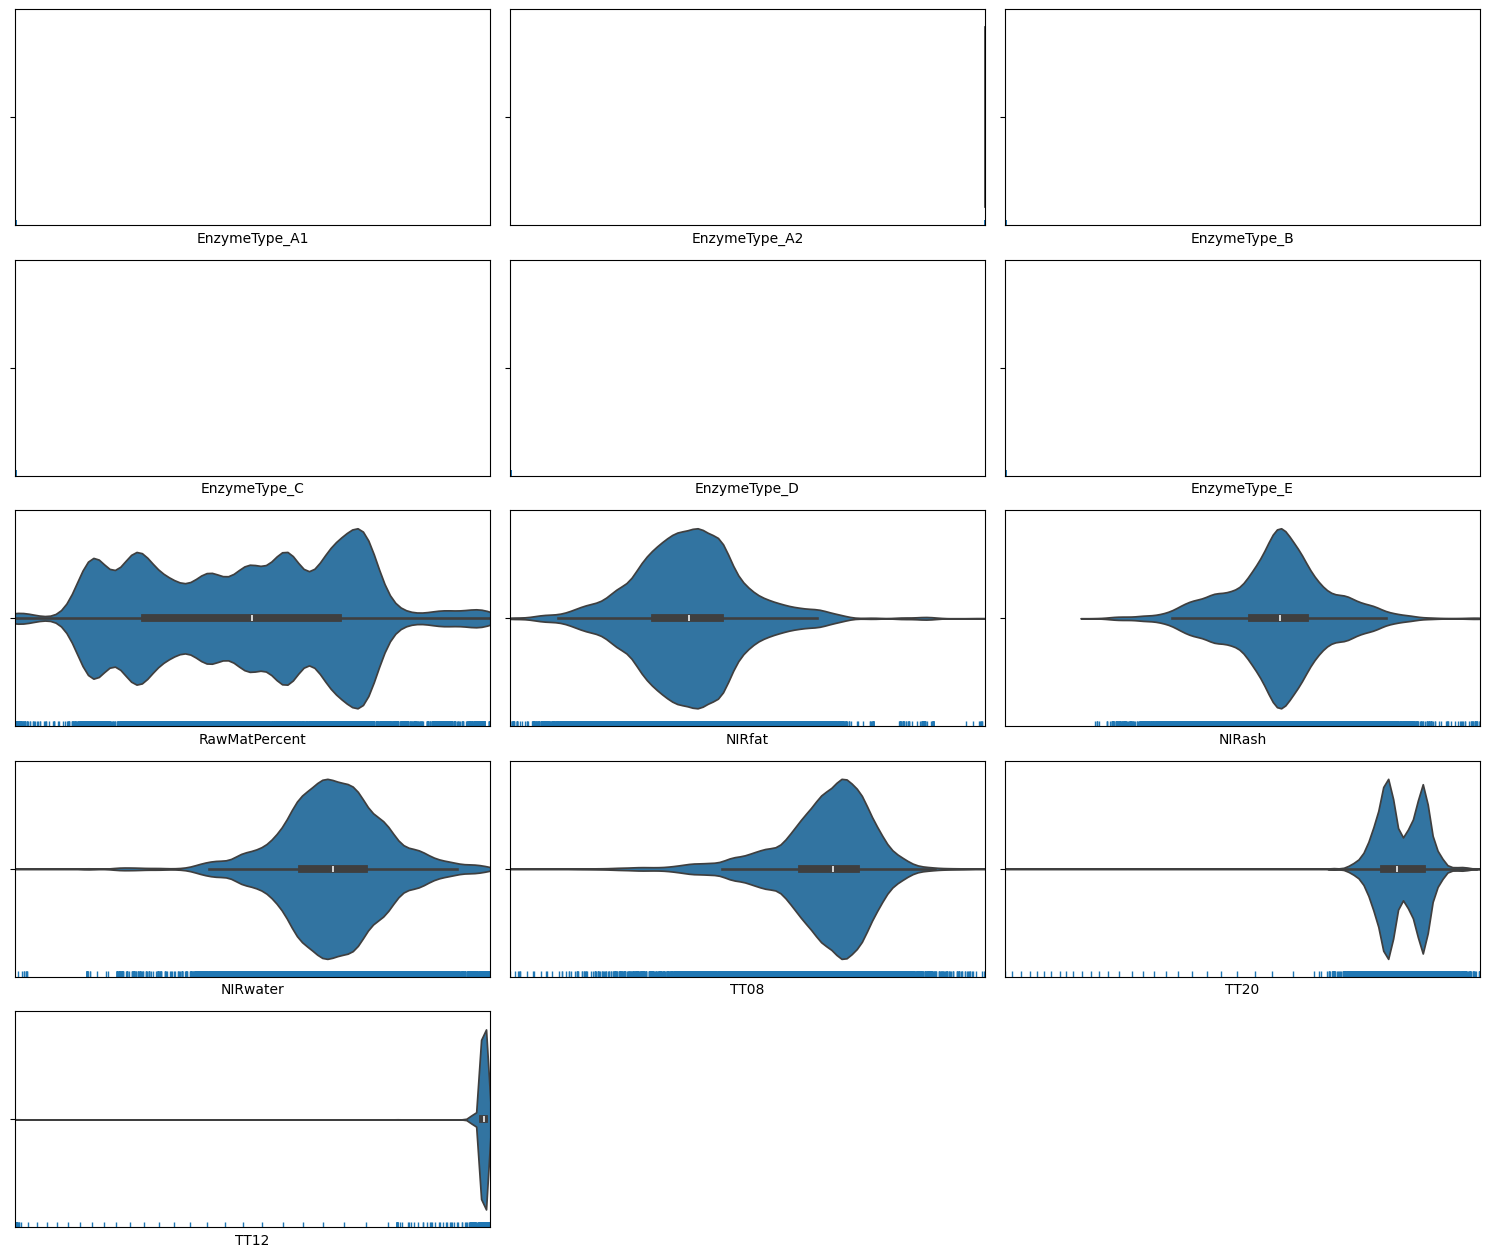

In [ ]:
# Violin plot av data for behandling og inspeksjon
plot_violin_grid(prediktor_normal, min_max_dict, fig_size=(15, 20))

# Behandling av normal data

In [ ]:
data_normal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18233 entries, 2022-11-02 10:47:00 to 2022-12-17 00:10:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   18233 non-null  int64  
 1   EnzymeType_A2   18233 non-null  int64  
 2   EnzymeType_B    18233 non-null  int64  
 3   EnzymeType_C    18233 non-null  int64  
 4   EnzymeType_D    18233 non-null  int64  
 5   EnzymeType_E    18233 non-null  int64  
 6   RawMatPercent   18233 non-null  float64
 7   NIRfat          18233 non-null  float64
 8   NIRash          18233 non-null  float64
 9   NIRwater        18233 non-null  float64
 10  TT08            18233 non-null  float64
 11  TT20            18233 non-null  float64
 12  TT12            18233 non-null  float64
 13  Collagen        33 non-null     float64
 14  Mw              160 non-null    float64
 15  SmallMolecules  160 non-null    float64
 16  BrixAdjusted    160 non-null    float64
d

## Ekstremsverdi inspeksjon med LOF

1.213761855300217


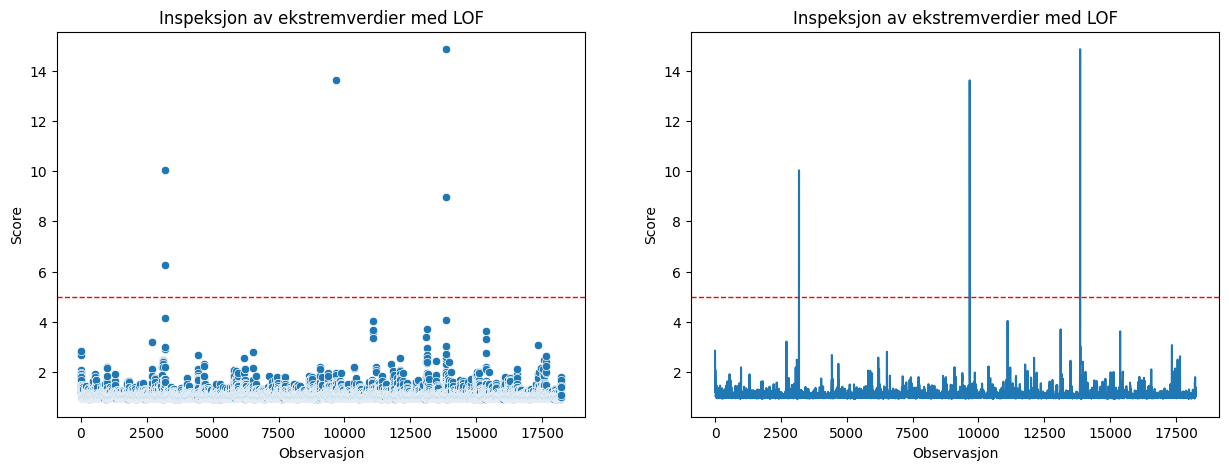

In [ ]:
# Ektremverdiinspeksjon med LOF på data
lof = LOF(n_neighbors=15)
lof.fit(X_normal)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_lof = lof.labels_
y_scores_lof = lof.decision_scores_
y_terskel_lof = lof.threshold_
print(y_terskel_lof)

#Setter terskel på score som anses som ekstrem observasjon
terskel_lof = 5

plot_ekstrem_score(y_scores_lof, terskel_lof, 'LOF', figsize=(15, 5))

Data etter behandling av ekstrem data med LOF

In [ ]:
# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_lof_indeks_normal = np.where(y_scores_lof > terskel_lof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_lof_terskel_normal = prediktor_normal.iloc[mulige_ekstrem_lof_indeks_normal]

# Utelukker ekstreme observasjoner fra data
behandlet_data_lof_normal = prediktor_normal.drop(prediktor_normal.index[mulige_ekstrem_lof_indeks_normal])

# Data etter inspeksjon med lof
print("Data etter lof:")
print(behandlet_data_lof_normal.info())

Data etter lof:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18228 entries, 2022-11-02 10:47:00 to 2022-12-17 00:10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnzymeType_A1  18228 non-null  int64  
 1   EnzymeType_A2  18228 non-null  int64  
 2   EnzymeType_B   18228 non-null  int64  
 3   EnzymeType_C   18228 non-null  int64  
 4   EnzymeType_D   18228 non-null  int64  
 5   EnzymeType_E   18228 non-null  int64  
 6   RawMatPercent  18228 non-null  float64
 7   NIRfat         18228 non-null  float64
 8   NIRash         18228 non-null  float64
 9   NIRwater       18228 non-null  float64
 10  TT08           18228 non-null  float64
 11  TT20           18228 non-null  float64
 12  TT12           18228 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 1.9 MB
None


## Ekstremsverdi inspeksjon med CBLOF

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5.882752630083887


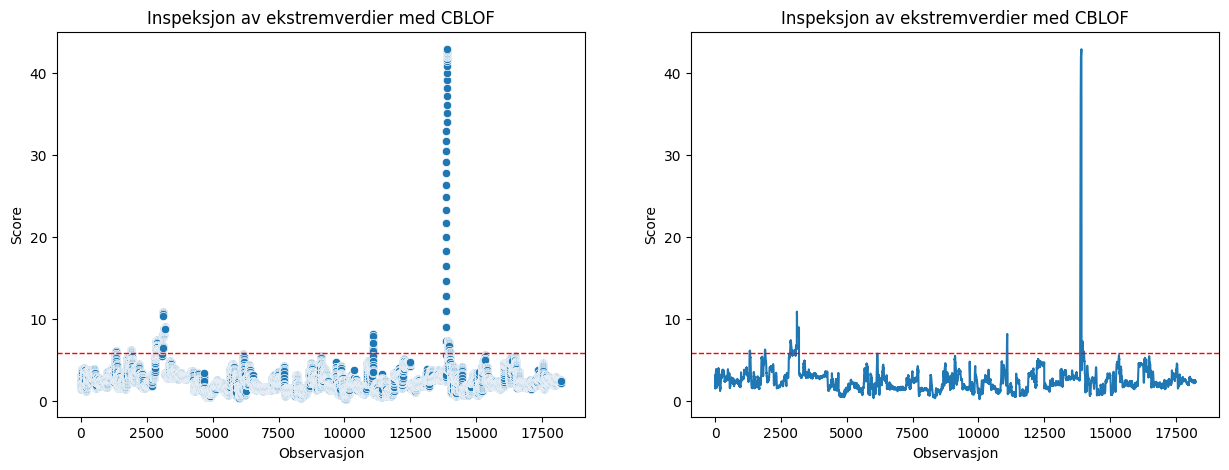

In [ ]:
# Ektremverdiinspeksjon med CBLOF på data

# Velger n_cluster lik antall enzymtyper*råmaterialetype kombinasjoner
n_clusters = kategorier_per_variabel(rå_data, data_normal, 'EnzymeCode', "RawMaterialMix")
_, _, antall_ekstremverdi_TT12_TT20= finn_beste_faktor_ekstrem_verdier_totalt(data_normal, 3.0, 15.0, ["TT12", "TT20"])
andel_ekstremverdier = antall_ekstremverdi_TT12_TT20/data_normal.shape[0]

cblof = CBLOF(n_clusters=n_clusters,
              contamination=andel_ekstremverdier,
              random_state=random_seed)
cblof.fit(X_normal)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_cblof = cblof.labels_
y_scores_cblof = cblof.decision_scores_
y_terskel_cblof = cblof.threshold_
print(y_terskel_cblof)

#Setter terskel på score som anses som ekstrem observasjon
terskel_cblof = 6

plot_ekstrem_score(y_scores_cblof, y_terskel_cblof, 'CBLOF', figsize=(15, 5))

In [ ]:
# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_cblof_indeks_normal = np.where(y_predikert_cblof != 0)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_cblof_terskel_normal = prediktor_normal.iloc[mulige_ekstrem_cblof_indeks_normal]

# Utelukker ekstreme observasjoner fra data
behandlet_data_cblof_normal = prediktor_normal.drop(prediktor_normal.index[mulige_ekstrem_cblof_indeks_normal])

# Data etter inspeksjon med CBLOF
print("Data etter CBLOF:")
print(behandlet_data_cblof_normal.info())

Data etter CBLOF:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17828 entries, 2022-11-02 10:47:00 to 2022-12-17 00:10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnzymeType_A1  17828 non-null  int64  
 1   EnzymeType_A2  17828 non-null  int64  
 2   EnzymeType_B   17828 non-null  int64  
 3   EnzymeType_C   17828 non-null  int64  
 4   EnzymeType_D   17828 non-null  int64  
 5   EnzymeType_E   17828 non-null  int64  
 6   RawMatPercent  17828 non-null  float64
 7   NIRfat         17828 non-null  float64
 8   NIRash         17828 non-null  float64
 9   NIRwater       17828 non-null  float64
 10  TT08           17828 non-null  float64
 11  TT20           17828 non-null  float64
 12  TT12           17828 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 1.9 MB
None


Violin plot

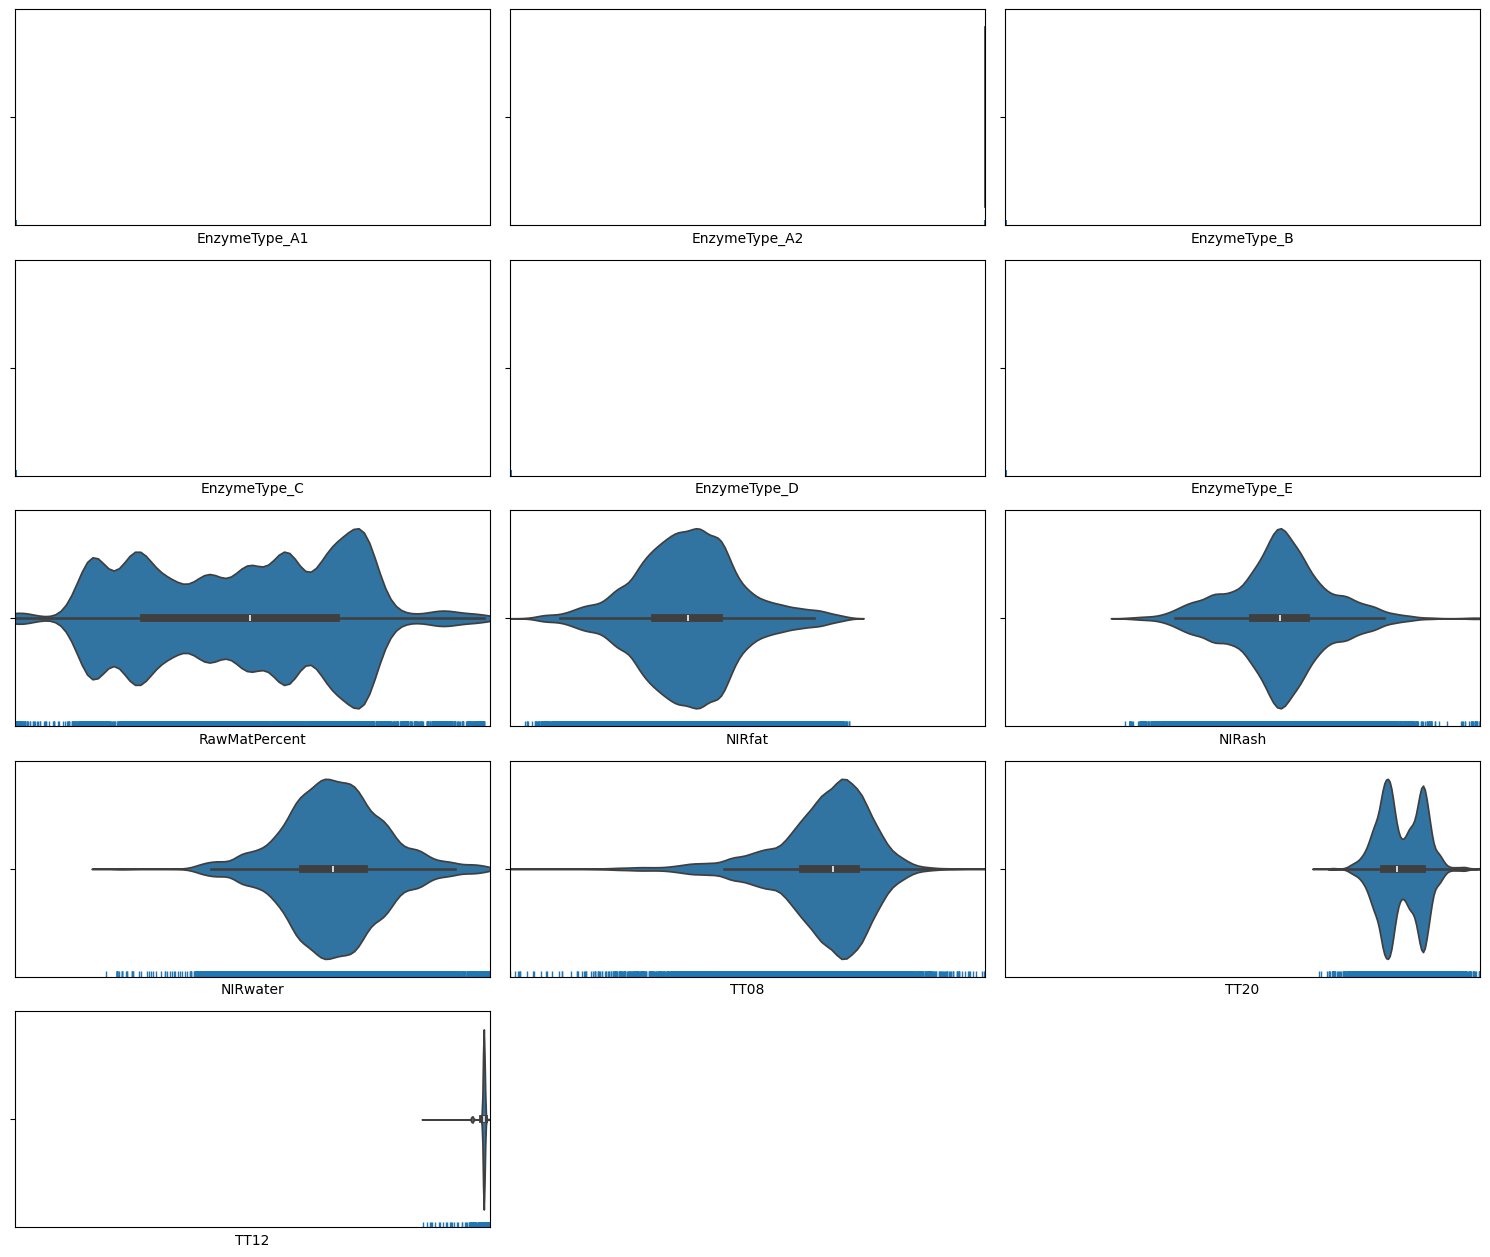

In [ ]:
# Violin plot av data etter behandling med CBLOF
plot_violin_grid(behandlet_data_cblof_normal, min_max_dict, fig_size=(15, 20))

### Inspeksjon av ekstrem data

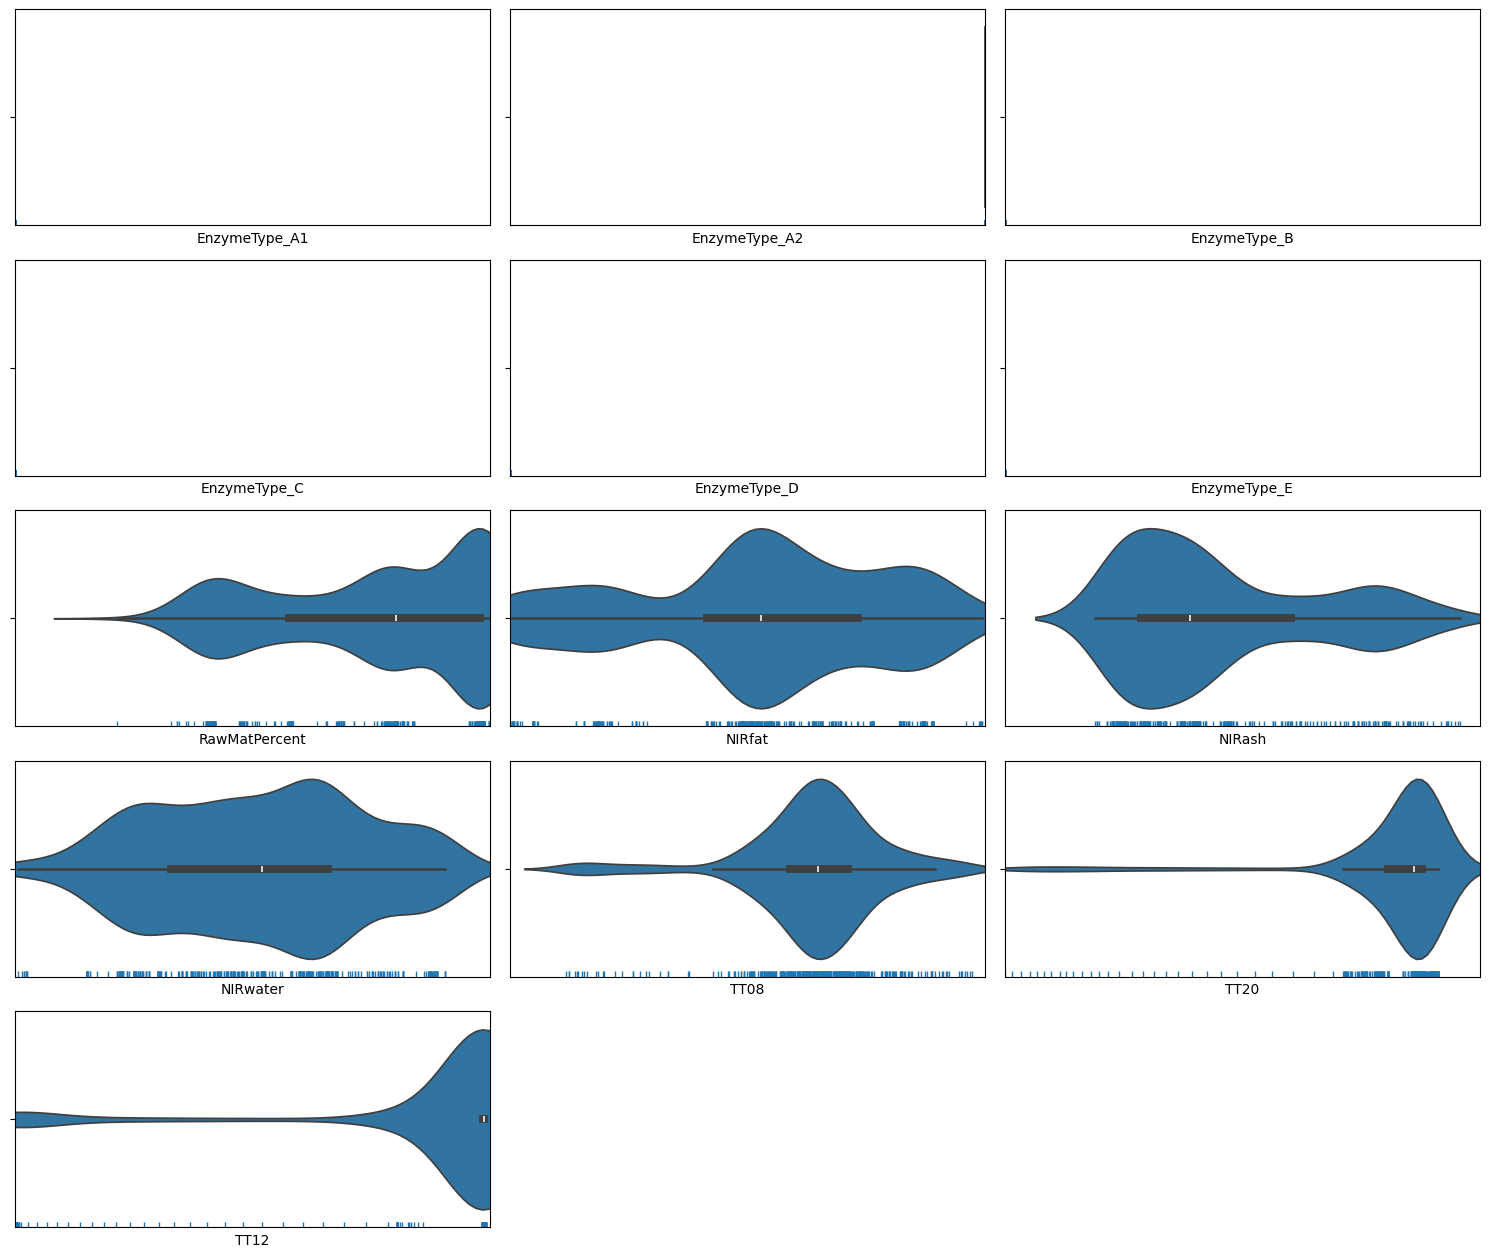

In [ ]:
# Violin plot av mulig ekstrem data av CBLOF
plot_violin_grid(mulige_ektrem_cblof_terskel_normal, min_max_dict, fig_size=(15, 20))

# Behandling av design data

In [ ]:
data_design.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10903 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   10903 non-null  int64  
 1   EnzymeType_A2   10903 non-null  int64  
 2   EnzymeType_B    10903 non-null  int64  
 3   EnzymeType_C    10903 non-null  int64  
 4   EnzymeType_D    10903 non-null  int64  
 5   EnzymeType_E    10903 non-null  int64  
 6   RawMatPercent   10903 non-null  float64
 7   NIRfat          10903 non-null  float64
 8   NIRash          10903 non-null  float64
 9   NIRwater        10903 non-null  float64
 10  TT08            10903 non-null  float64
 11  TT20            10903 non-null  float64
 12  TT12            10903 non-null  float64
 13  Collagen        56 non-null     float64
 14  Mw              300 non-null    float64
 15  SmallMolecules  300 non-null    float64
 16  BrixAdjusted    300 non-null    float64
d

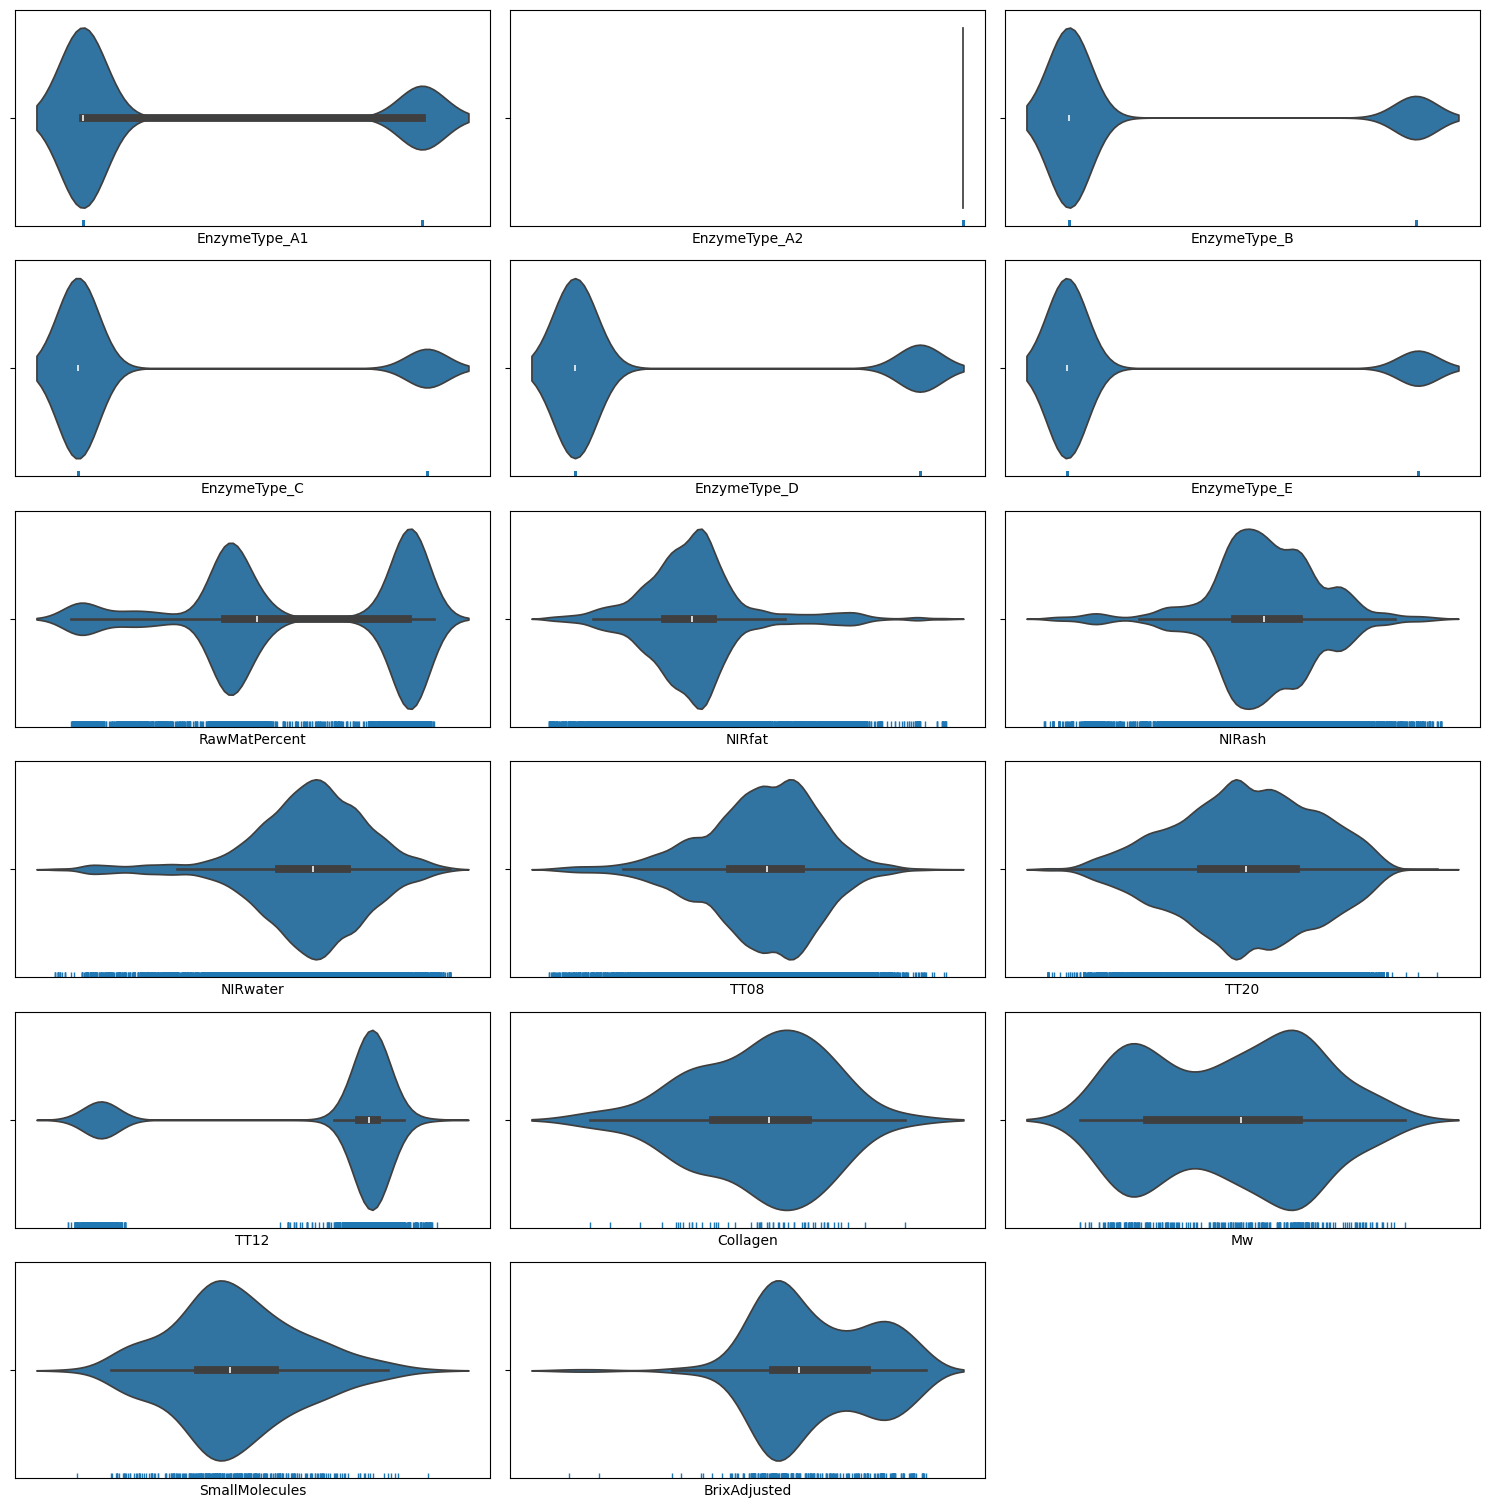

In [ ]:
plot_violin_grid(data_design, fig_size=(15, 20))

In [ ]:
_, data, _ = finn_beste_faktor_ekstrem_verdier_totalt(data_design, 3.0, 10.0, ['NIRfat'])

In [ ]:
kategoriske_fordelinger(data_design)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A1           | 2845       | 26.0937     |
| D            | 2256       | 20.6916     |
| B            | 2113       | 19.38       |
| C            | 1916       | 17.5731     |
| E            | 1773       | 16.2616     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 10495      | 96.2579     |
| Turkey           | 215        | 1.97193     |
| Chicken          | 193        | 1.77016     |


In [ ]:
kategoriske_fordelinger(filtered_data)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| C            | 75         | 70.0935     |
| D            | 24         | 22.4299     |
| E            | 8          | 7.47664     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 75         | 70.0935     |
| Turkey           | 32         | 29.9065     |


## Ekstremsverdi inspeksjon med LOF

1.2196036148303866


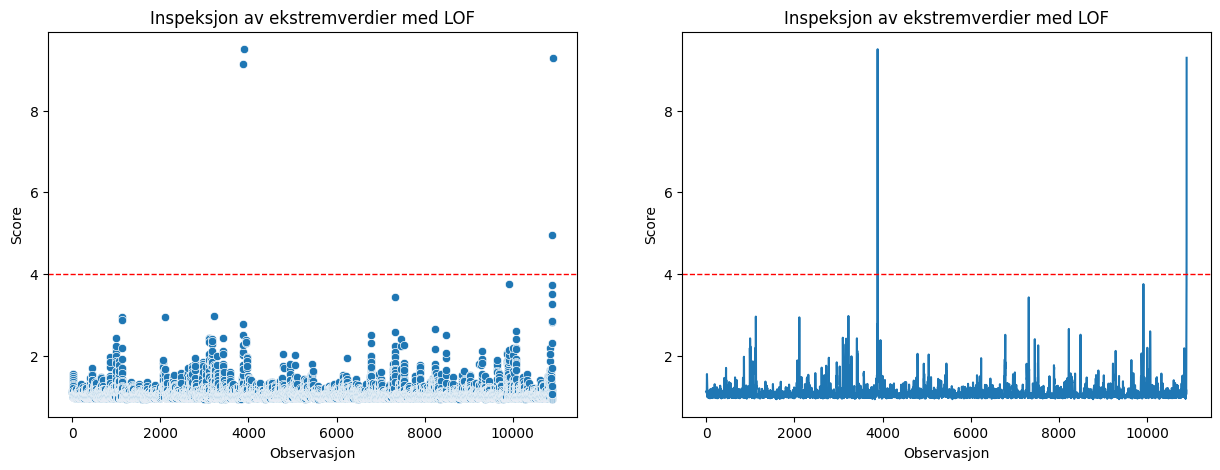

In [ ]:
# Ektremverdiinspeksjon med LOF på data
lof = LOF(n_neighbors=15)
lof.fit(X_design)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_lof = lof.labels_
y_scores_lof = lof.decision_scores_
y_terskel_lof = lof.threshold_
print(y_terskel_lof)

#Setter terskel på score som anses som ekstrem observasjon
terskel_lof = 4

plot_ekstrem_score(y_scores_lof, terskel_lof, 'LOF', figsize=(15, 5))

Data etter behandling av ekstrem data med LOF

In [ ]:
# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_lof_indeks_design = np.where(y_scores_lof > terskel_lof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_lof_terskel_design = prediktor_design.iloc[mulige_ekstrem_lof_indeks_design]

# Utelukker ekstreme observasjoner fra data
behandlet_data_lof_design = prediktor_design.drop(prediktor_design.index[mulige_ekstrem_lof_indeks_design])

# Data etter inspeksjon med lof
print("Data etter lof:")
print(behandlet_data_lof_design.info())

Data etter lof:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10899 entries, 2022-10-31 17:37:00 to 2023-06-14 01:04:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnzymeType_A1  10899 non-null  int64  
 1   EnzymeType_A2  10899 non-null  int64  
 2   EnzymeType_B   10899 non-null  int64  
 3   EnzymeType_C   10899 non-null  int64  
 4   EnzymeType_D   10899 non-null  int64  
 5   EnzymeType_E   10899 non-null  int64  
 6   RawMatPercent  10899 non-null  float64
 7   NIRfat         10899 non-null  float64
 8   NIRash         10899 non-null  float64
 9   NIRwater       10899 non-null  float64
 10  TT08           10899 non-null  float64
 11  TT20           10899 non-null  float64
 12  TT12           10899 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 1.2 MB
None


Violin plot

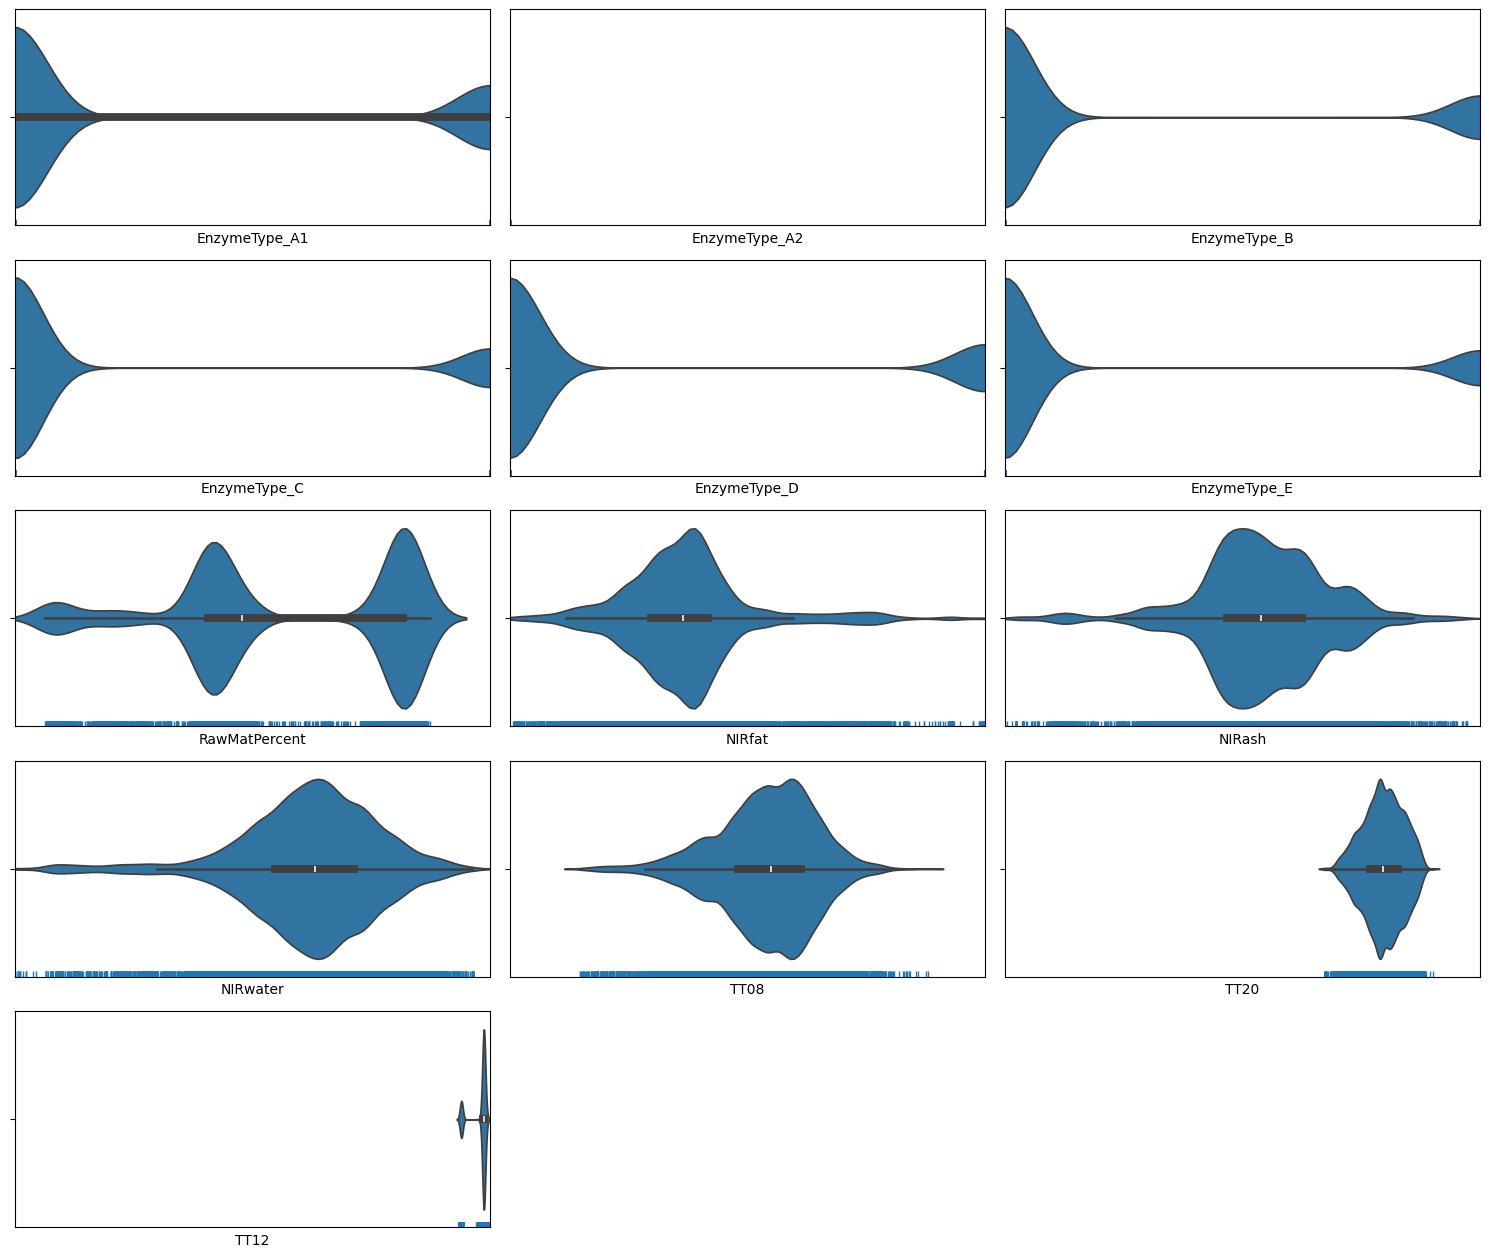

In [ ]:
# Violin plot av data etter behandling med LOF
plot_violin_grid(behandlet_data_lof_design, min_max_dict, fig_size=(15, 20))

### Inspeksjon av ekstrem data

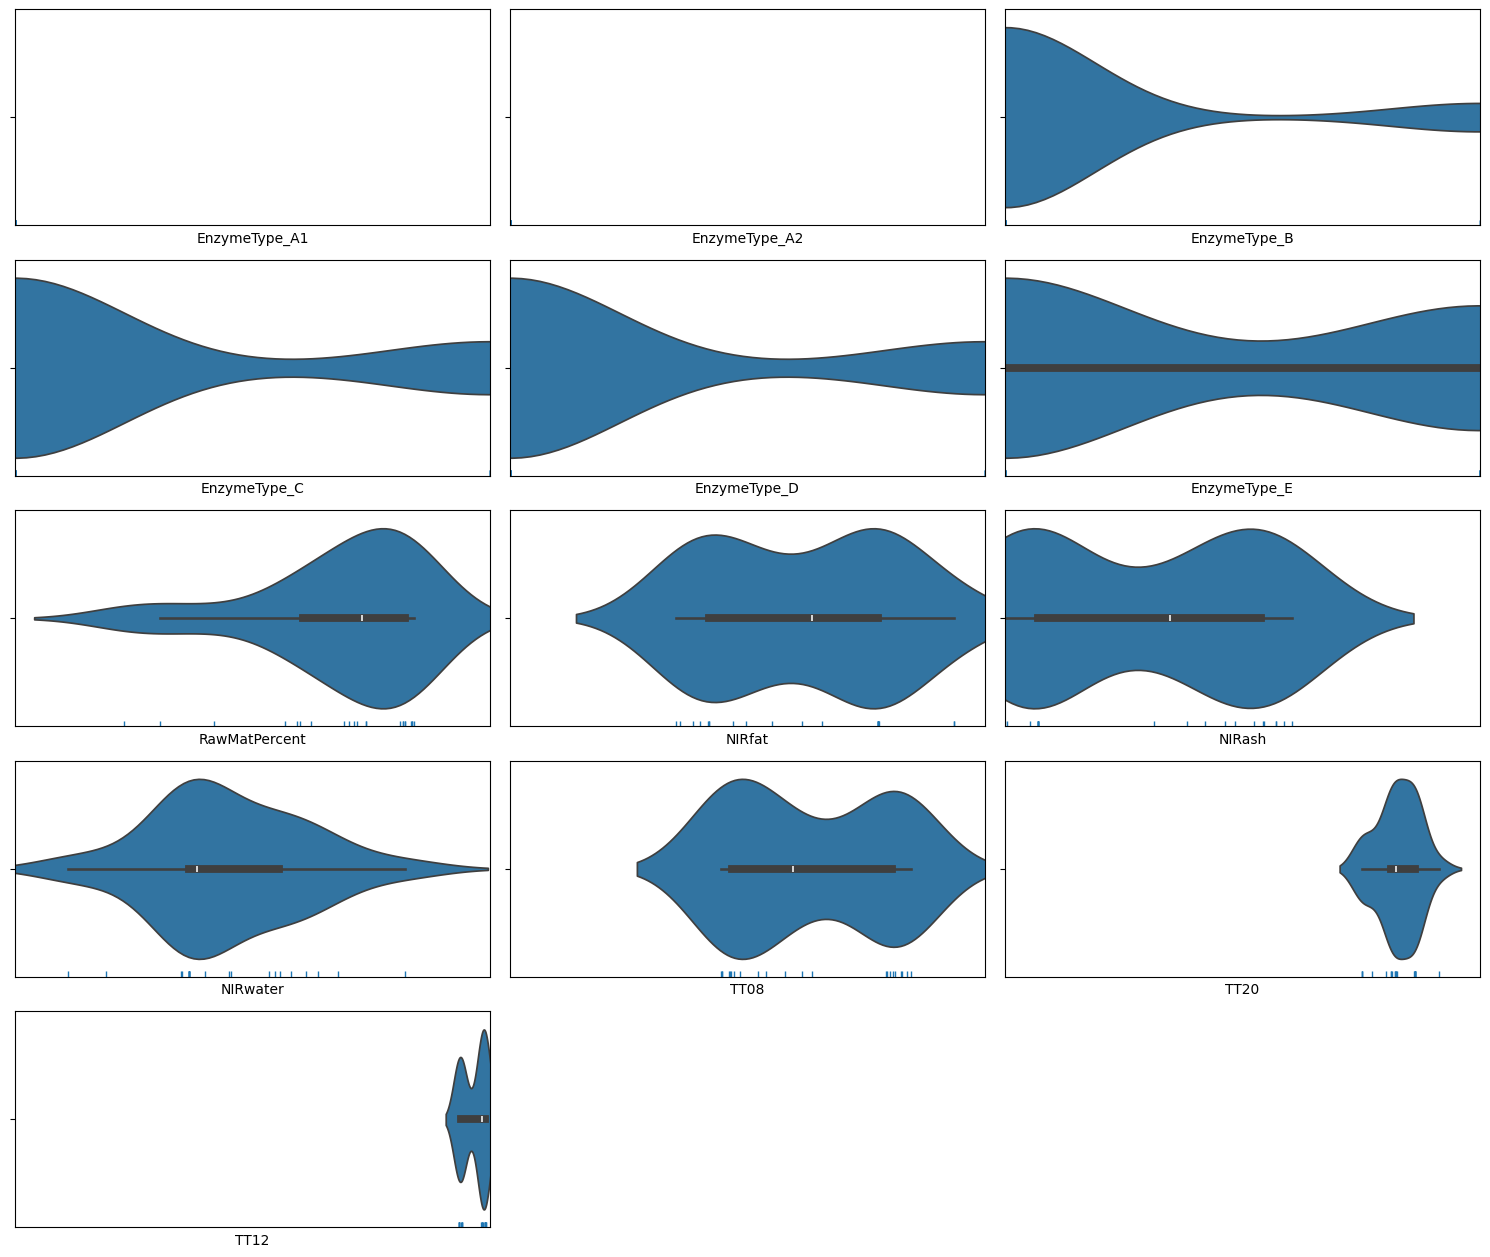

In [ ]:
# Violin plot av mulig ekstrem data av CBLOF
plot_violin_grid(mulige_ektrem_lof_terskel_design, min_max_dict, fig_size=(15, 20))

In [ ]:
kategoriske_fordelinger(mulige_ektrem_lof_terskel_design)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| C            | 2          | 50          |
| E            | 2          | 50          |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 4          | 100         |


# Samlet behandling for ekstrem data

In [ ]:
# Ekskluderer ektrem data fra original data med forklaringsvariabler
data_behandlet_normal = behandlet_data.drop(prediktor_normal.index[mulige_ekstrem_cblof_indeks_normal])
data_behandlet_normal = data_behandlet_normal.drop(prediktor_normal.index[mulige_ekstrem_lof_indeks_normal], errors='ignore')


# Data før behandling
print("Data etter felles inspeksjon:")
print(behandlet_data.info())
# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(data_behandlet_normal.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29136 non-null  int64  
 1   EnzymeType_A2   29136 non-null  int64  
 2   EnzymeType_B    29136 non-null  int64  
 3   EnzymeType_C    29136 non-null  int64  
 4   EnzymeType_D    29136 non-null  int64  
 5   EnzymeType_E    29136 non-null  int64  
 6   RawMatPercent   29136 non-null  float64
 7   NIRfat          29136 non-null  float64
 8   NIRash          29136 non-null  float64
 9   NIRwater        29136 non-null  float64
 10  TT08            29136 non-null  float64
 11  TT20            29136 non-null  float64
 12  TT12            29136 non-null  float64
 13  Collagen        89 non-null     float64
 14  Mw              460 non-null    float64
 15  SmallMolecules  460 non-null    float64
 16  BrixAdjuste

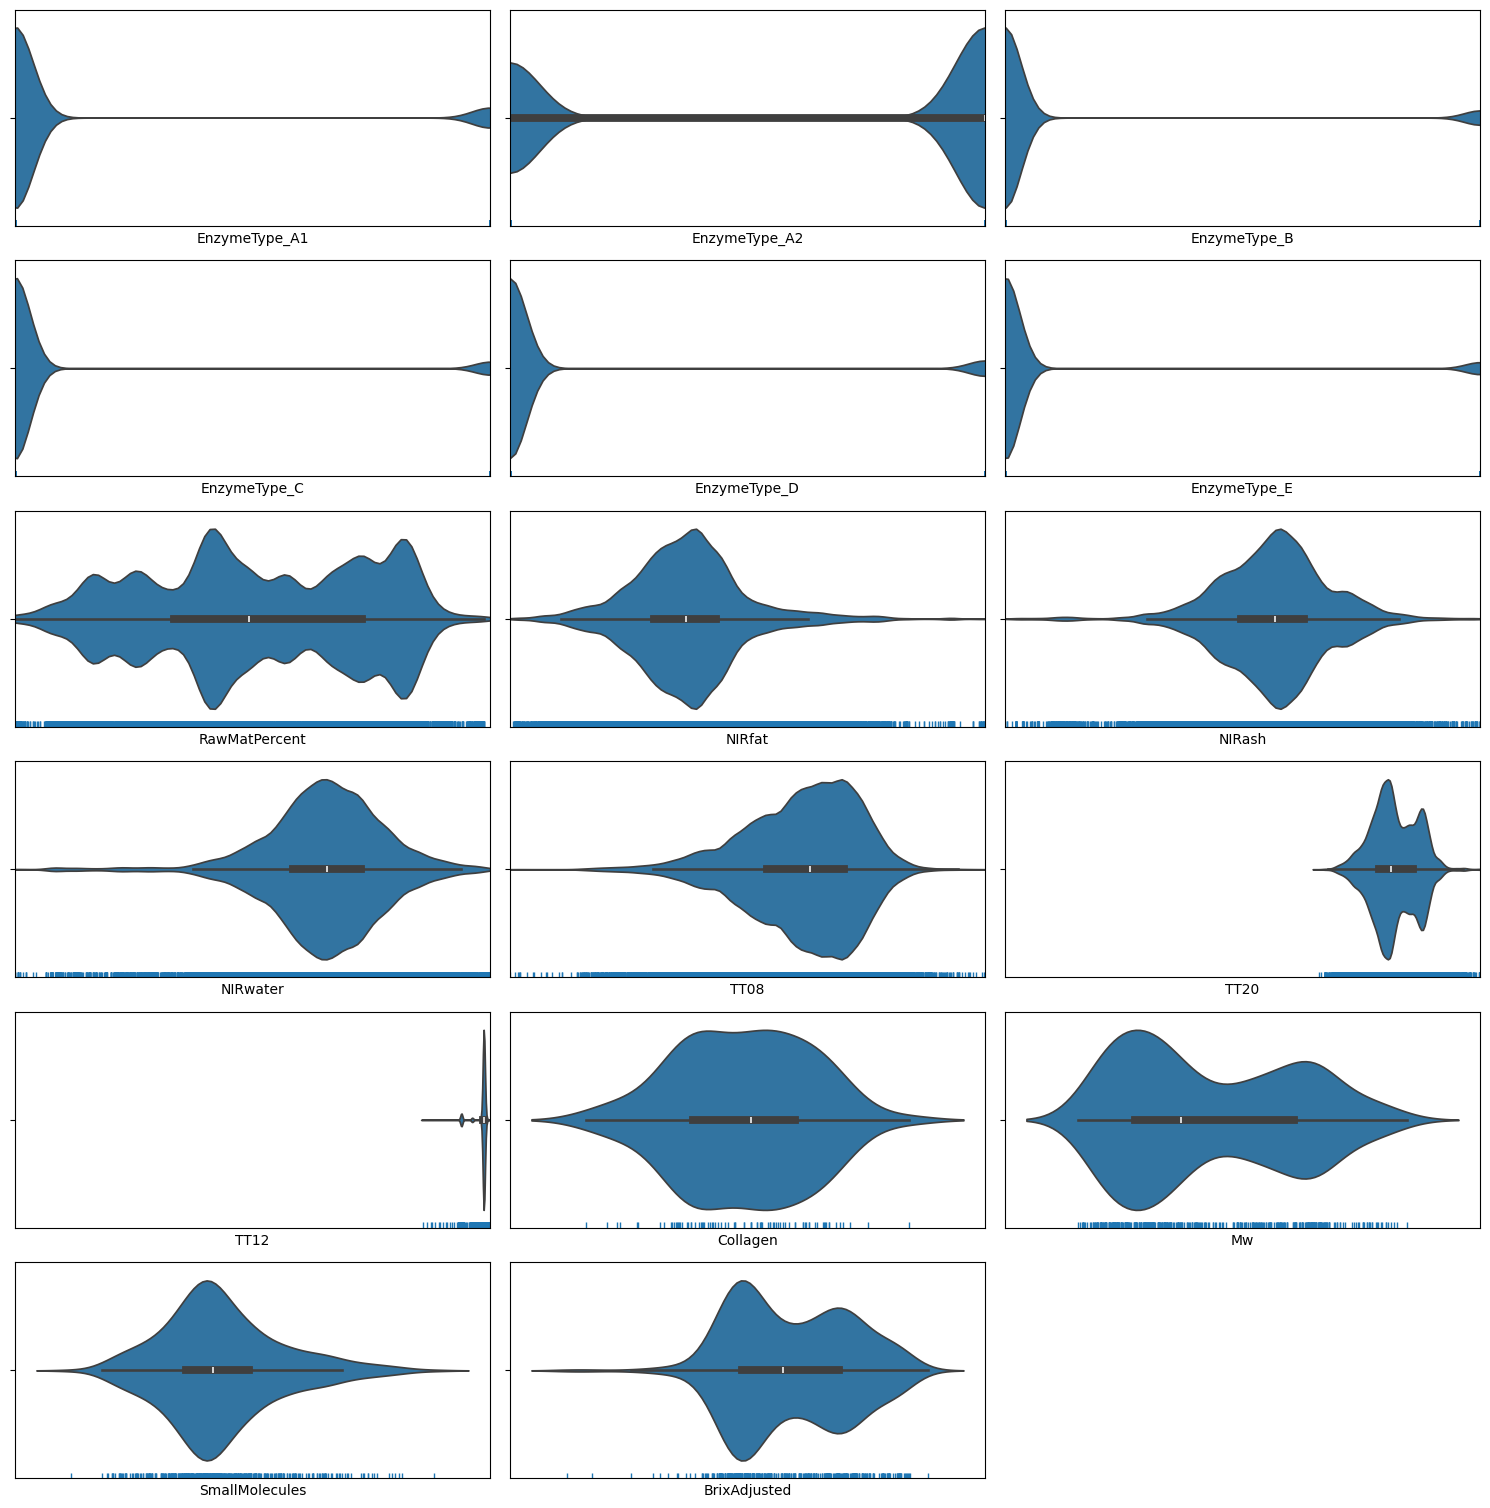

In [ ]:
plot_violin_grid(data_behandlet_normal, min_max_dict, fig_size=(15, 20))

In [ ]:
# Ekskluderer ektrem data fra original data med forklaringsvariabler
data_behandlet = data_behandlet_normal.drop(prediktor_design.index[mulige_ekstrem_lof_indeks_design])

# Data før behandling
print("Data etter felles inspeksjon:")
print(data_behandlet_normal.info())
# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(data_behandlet.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28728 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28728 non-null  int64  
 1   EnzymeType_A2   28728 non-null  int64  
 2   EnzymeType_B    28728 non-null  int64  
 3   EnzymeType_C    28728 non-null  int64  
 4   EnzymeType_D    28728 non-null  int64  
 5   EnzymeType_E    28728 non-null  int64  
 6   RawMatPercent   28728 non-null  float64
 7   NIRfat          28728 non-null  float64
 8   NIRash          28728 non-null  float64
 9   NIRwater        28728 non-null  float64
 10  TT08            28728 non-null  float64
 11  TT20            28728 non-null  float64
 12  TT12            28728 non-null  float64
 13  Collagen        83 non-null     float64
 14  Mw              448 non-null    float64
 15  SmallMolecules  448 non-null    float64
 16  BrixAdjuste

Violin plot

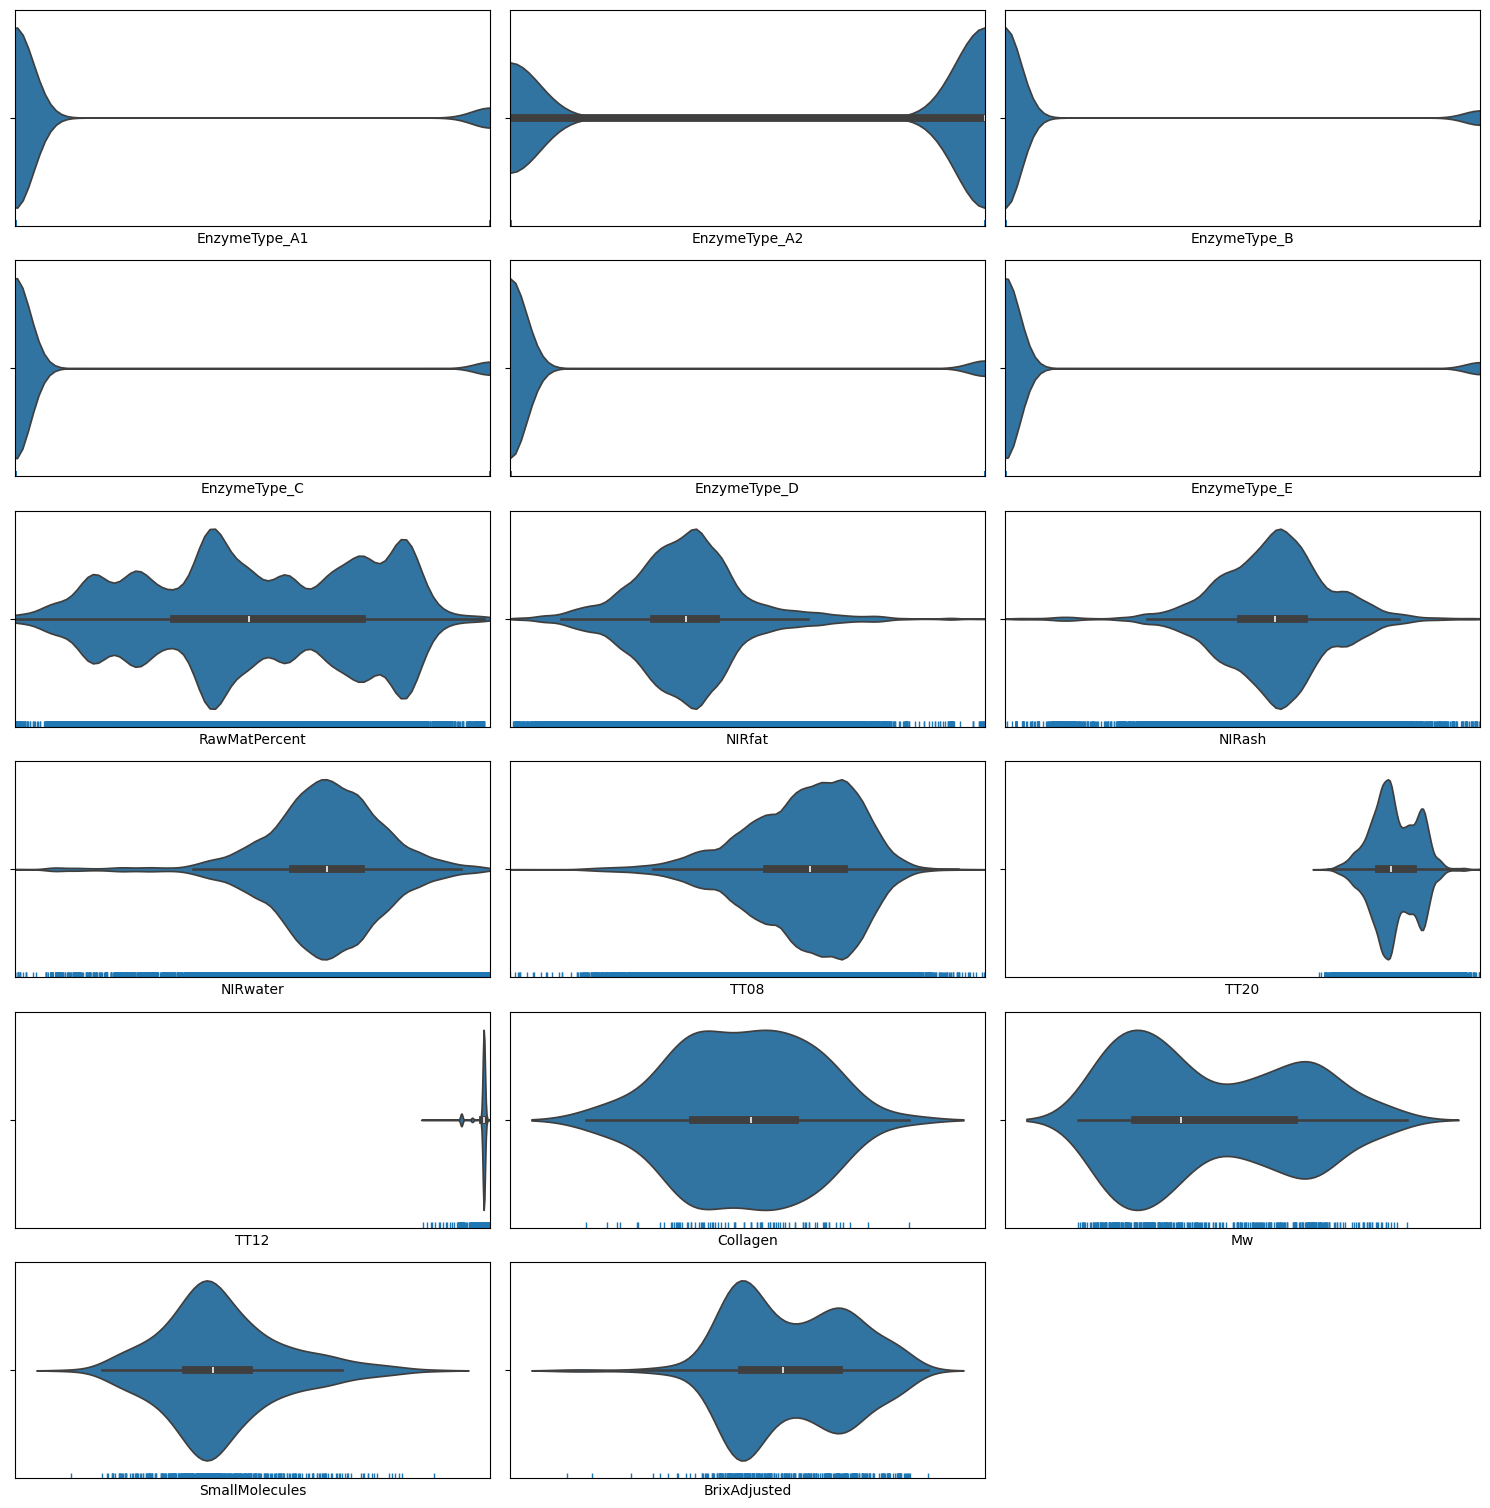

In [ ]:
# Violin plot av data etter behandling for ekstrem data
plot_violin_grid(data_behandlet, min_max_dict, fig_size=(15, 20))

Informasjon om hele datasett ekskludert ekstrem data

In [ ]:
# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(data_behandlet.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28724 entries, 2022-10-31 17:37:00 to 2023-06-14 01:04:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28724 non-null  int64  
 1   EnzymeType_A2   28724 non-null  int64  
 2   EnzymeType_B    28724 non-null  int64  
 3   EnzymeType_C    28724 non-null  int64  
 4   EnzymeType_D    28724 non-null  int64  
 5   EnzymeType_E    28724 non-null  int64  
 6   RawMatPercent   28724 non-null  float64
 7   NIRfat          28724 non-null  float64
 8   NIRash          28724 non-null  float64
 9   NIRwater        28724 non-null  float64
 10  TT08            28724 non-null  float64
 11  TT20            28724 non-null  float64
 12  TT12            28724 non-null  float64
 13  Collagen        83 non-null     float64
 14  Mw              448 non-null    float64
 15  SmallMolecules  448 non-null    float64
 16  BrixAdjuste

# Inspeksjon av gjenværende umarkert data

## Deler datasettet i markert og umarkert

In [ ]:
# Splitter data i design og normal sett
data_markert, data_umarkert = splitt_markert_umarkert(data_behandlet)

# Markert
prediktor_markert = data_markert.iloc[:, :-4]
X_markert= prediktor_markert.values

min_max_dict_markert = {}
for col in prediktor_markert.columns:
  min_max_dict_markert[col] = [prediktor_markert[col].min(), prediktor_markert[col].max()]

# Umarkert
prediktor_umarkert = data_umarkert.iloc[:, :-4]
X_umarkert = prediktor_umarkert.values

min_max_dict_umarkert = {}
for col in prediktor_umarkert.columns:
  min_max_dict_umarkert[col] = [prediktor_umarkert[col].min(), prediktor_umarkert[col].max()]

### Inspeksjon av markert data

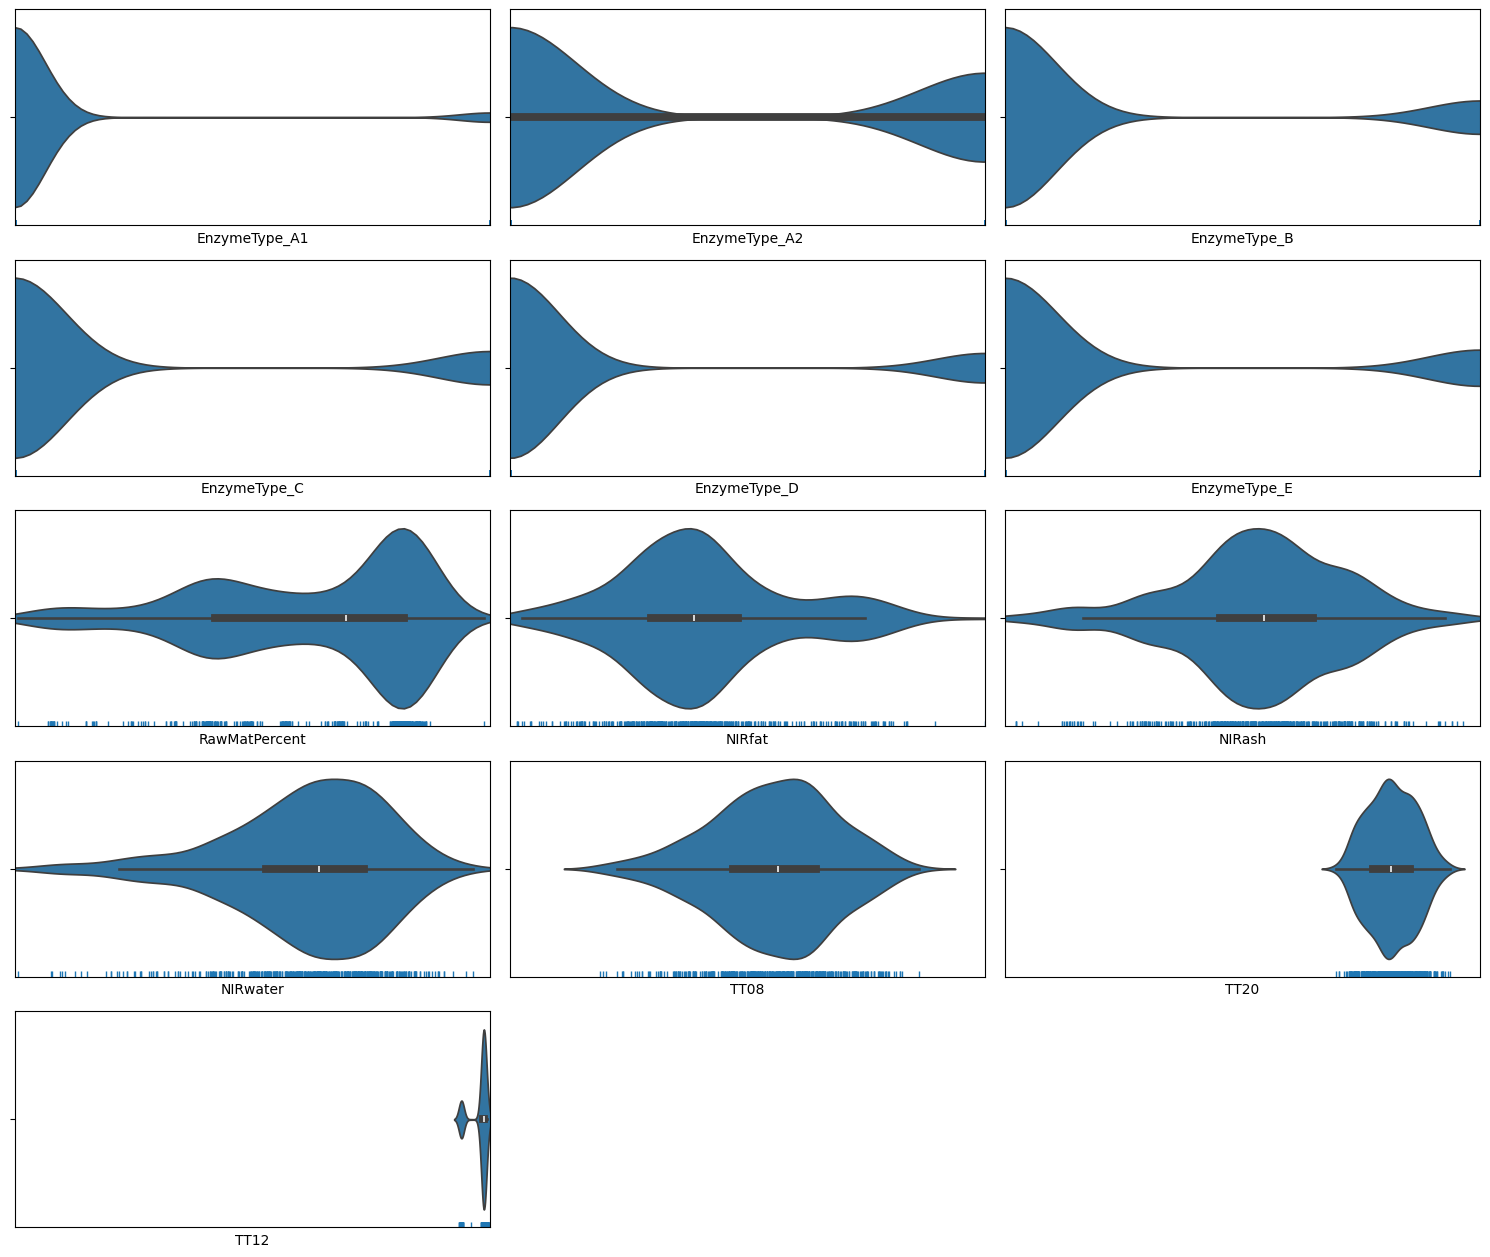

In [ ]:
# Violin plot av data for behandling og inspeksjon
plot_violin_grid(prediktor_markert, min_max_dict, fig_size=(15, 20))

### Inspeksjon av umarkert data

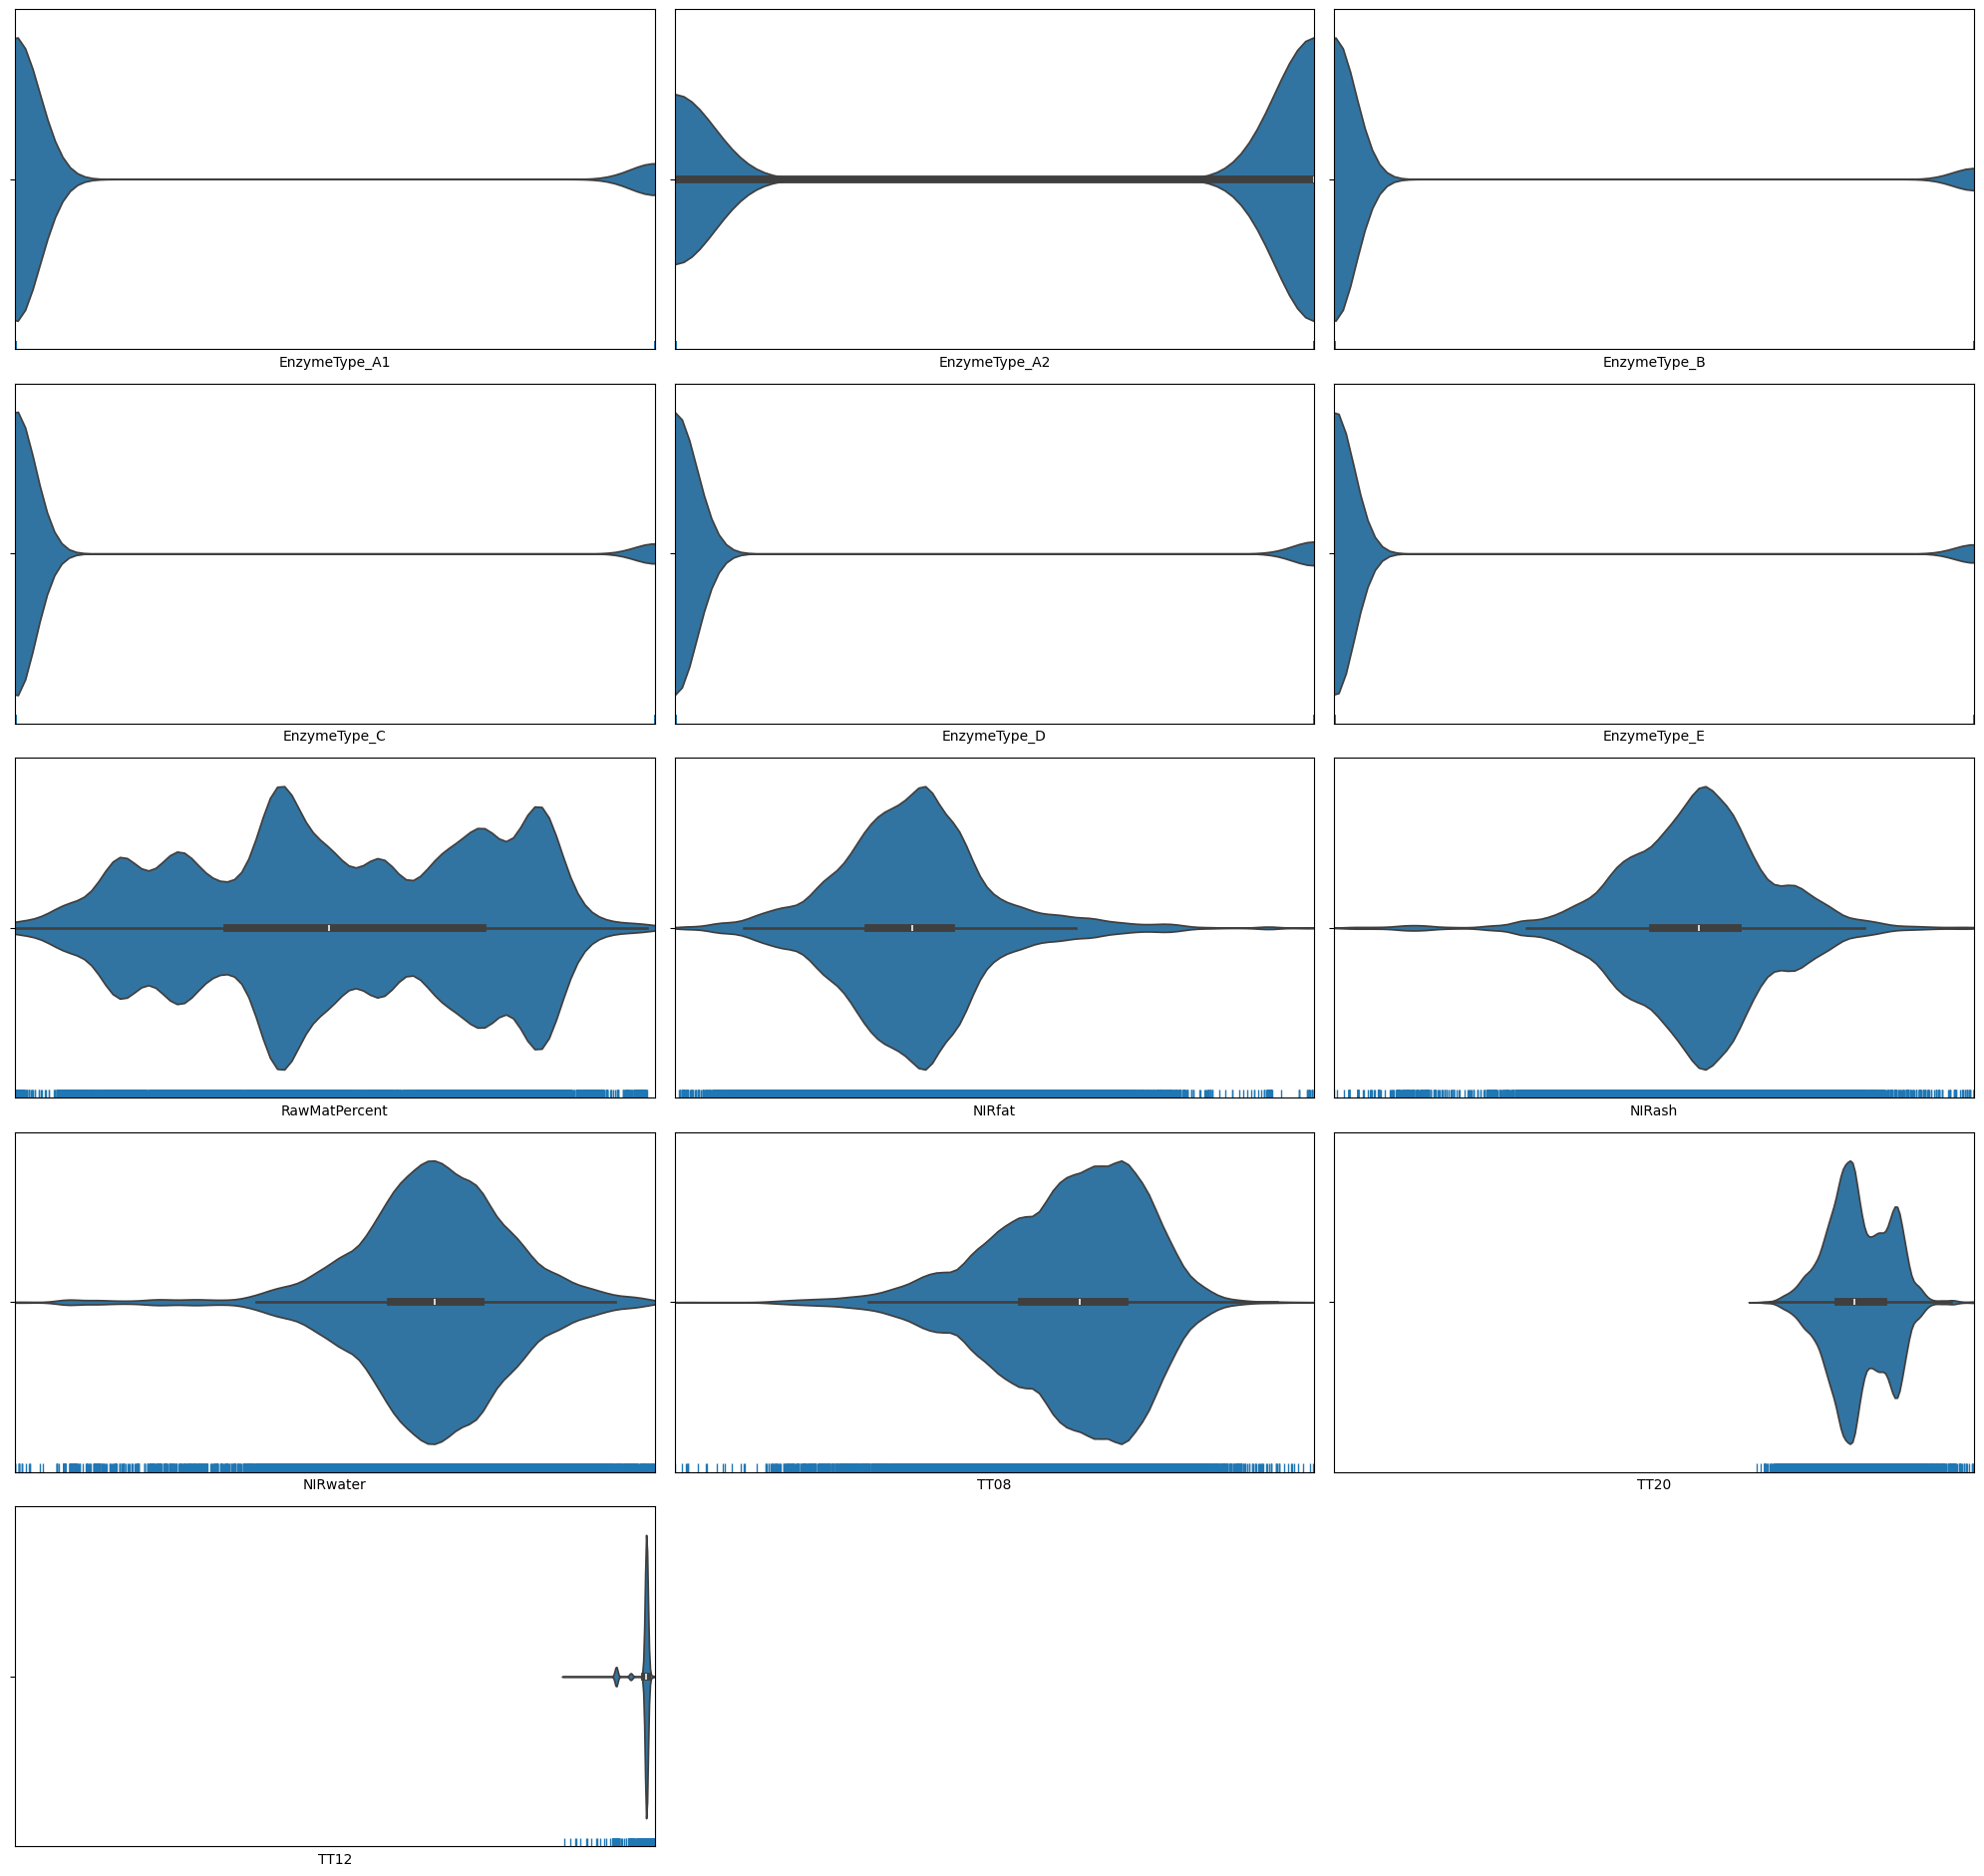

In [ ]:
# Violin plot av data for behandling og inspeksjon
plot_violin_grid(prediktor_umarkert, min_max_dict, fig_size=(20, 30))

In [ ]:
data_umarkert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28276 entries, 2022-10-31 17:37:00 to 2023-06-14 01:04:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28276 non-null  int64  
 1   EnzymeType_A2   28276 non-null  int64  
 2   EnzymeType_B    28276 non-null  int64  
 3   EnzymeType_C    28276 non-null  int64  
 4   EnzymeType_D    28276 non-null  int64  
 5   EnzymeType_E    28276 non-null  int64  
 6   RawMatPercent   28276 non-null  float64
 7   NIRfat          28276 non-null  float64
 8   NIRash          28276 non-null  float64
 9   NIRwater        28276 non-null  float64
 10  TT08            28276 non-null  float64
 11  TT20            28276 non-null  float64
 12  TT12            28276 non-null  float64
 13  Collagen        0 non-null      float64
 14  Mw              0 non-null      float64
 15  SmallMolecules  0 non-null      float64
 16  BrixAdjusted    0 non-null      float64
d

## Ekstremsverdi inspeksjon med LOF

1.2139211209520928


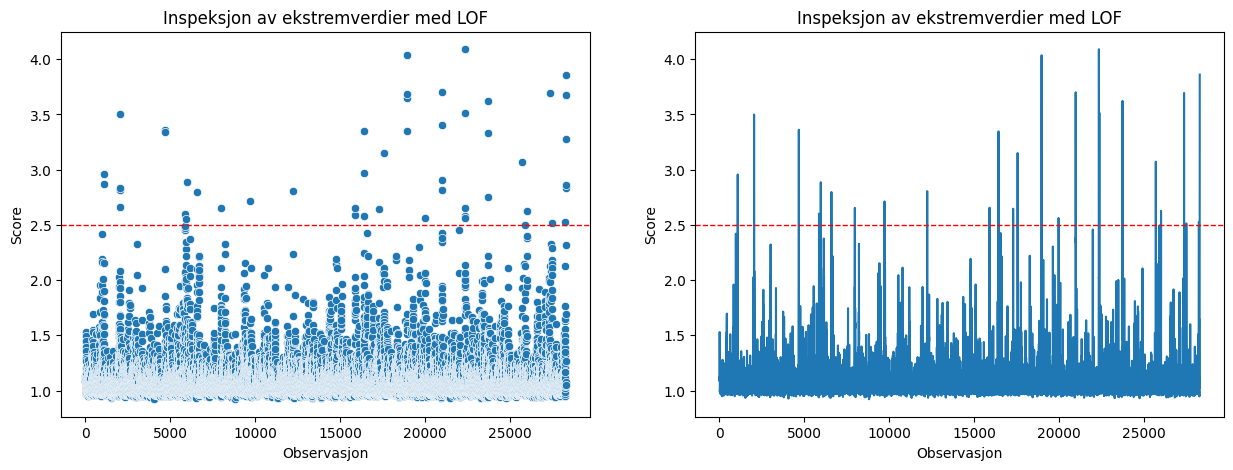

In [ ]:
# Ektremverdiinspeksjon med LOF på data
lof = LOF(n_neighbors=15)
lof.fit(X_umarkert)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_lof = lof.labels_
y_scores_lof = lof.decision_scores_
y_terskel_lof = lof.threshold_
print(y_terskel_lof)

#Setter terskel på score som anses som ekstrem observasjon
terskel_lof = 2.5

plot_ekstrem_score(y_scores_lof, terskel_lof, 'LOF', figsize=(15, 5))

Data etter behandling av ekstrem data med LOF

In [ ]:
# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_lof_indeks_umarkert = np.where(y_scores_lof > terskel_lof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ekstrem_lof_terskel_umarkert = prediktor_umarkert.iloc[mulige_ekstrem_lof_indeks_umarkert]

# Utelukker ekstreme observasjoner fra data
behandlet_data_lof_umarkert = prediktor_umarkert.drop(prediktor_umarkert.index[mulige_ekstrem_lof_indeks_umarkert])

# Data etter inspeksjon med lof
print("Data etter lof:")
print(behandlet_data_lof_umarkert.info())

Data etter lof:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27569 entries, 2022-10-31 17:37:00 to 2023-06-14 00:57:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnzymeType_A1  27569 non-null  int64  
 1   EnzymeType_A2  27569 non-null  int64  
 2   EnzymeType_B   27569 non-null  int64  
 3   EnzymeType_C   27569 non-null  int64  
 4   EnzymeType_D   27569 non-null  int64  
 5   EnzymeType_E   27569 non-null  int64  
 6   RawMatPercent  27569 non-null  float64
 7   NIRfat         27569 non-null  float64
 8   NIRash         27569 non-null  float64
 9   NIRwater       27569 non-null  float64
 10  TT08           27569 non-null  float64
 11  TT20           27569 non-null  float64
 12  TT12           27569 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 2.9 MB
None


Violin plot

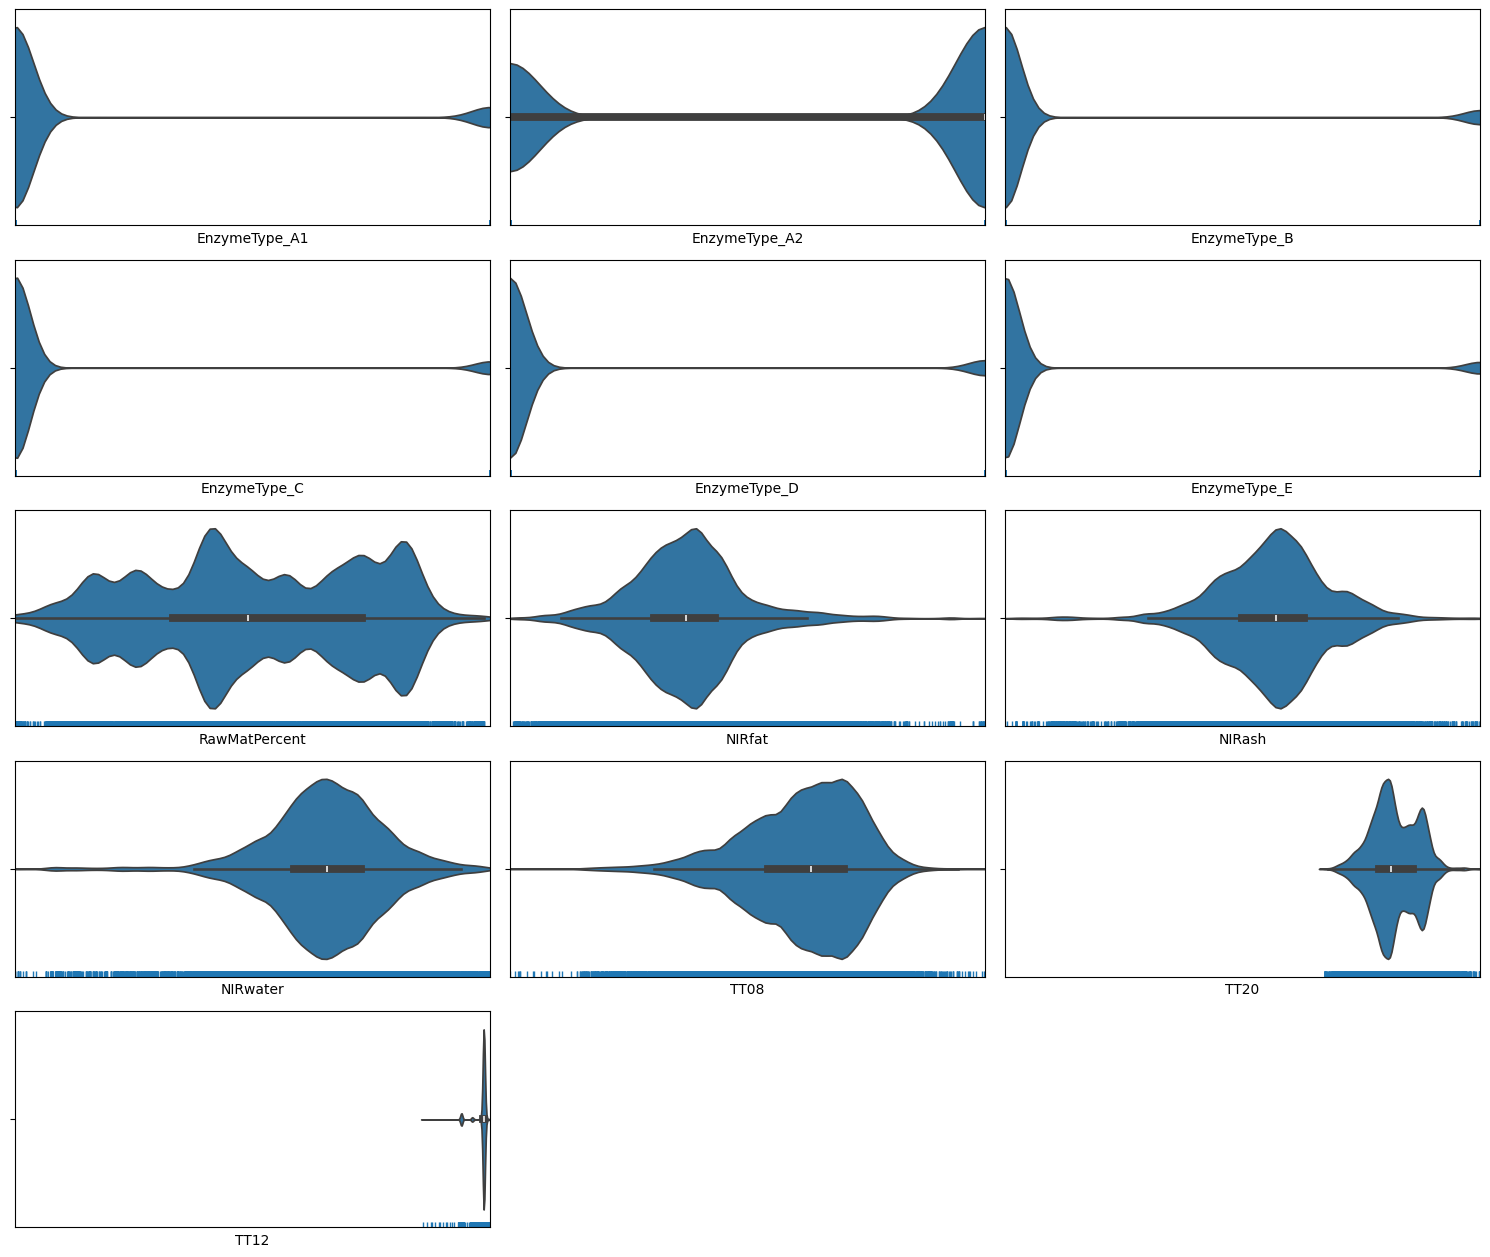

In [ ]:
# Violin plot av data etter behandling med CBLOF
plot_violin_grid(behandlet_data_lof_umarkert, min_max_dict, fig_size=(15, 20))

### Inspeksjon av ekstrem data

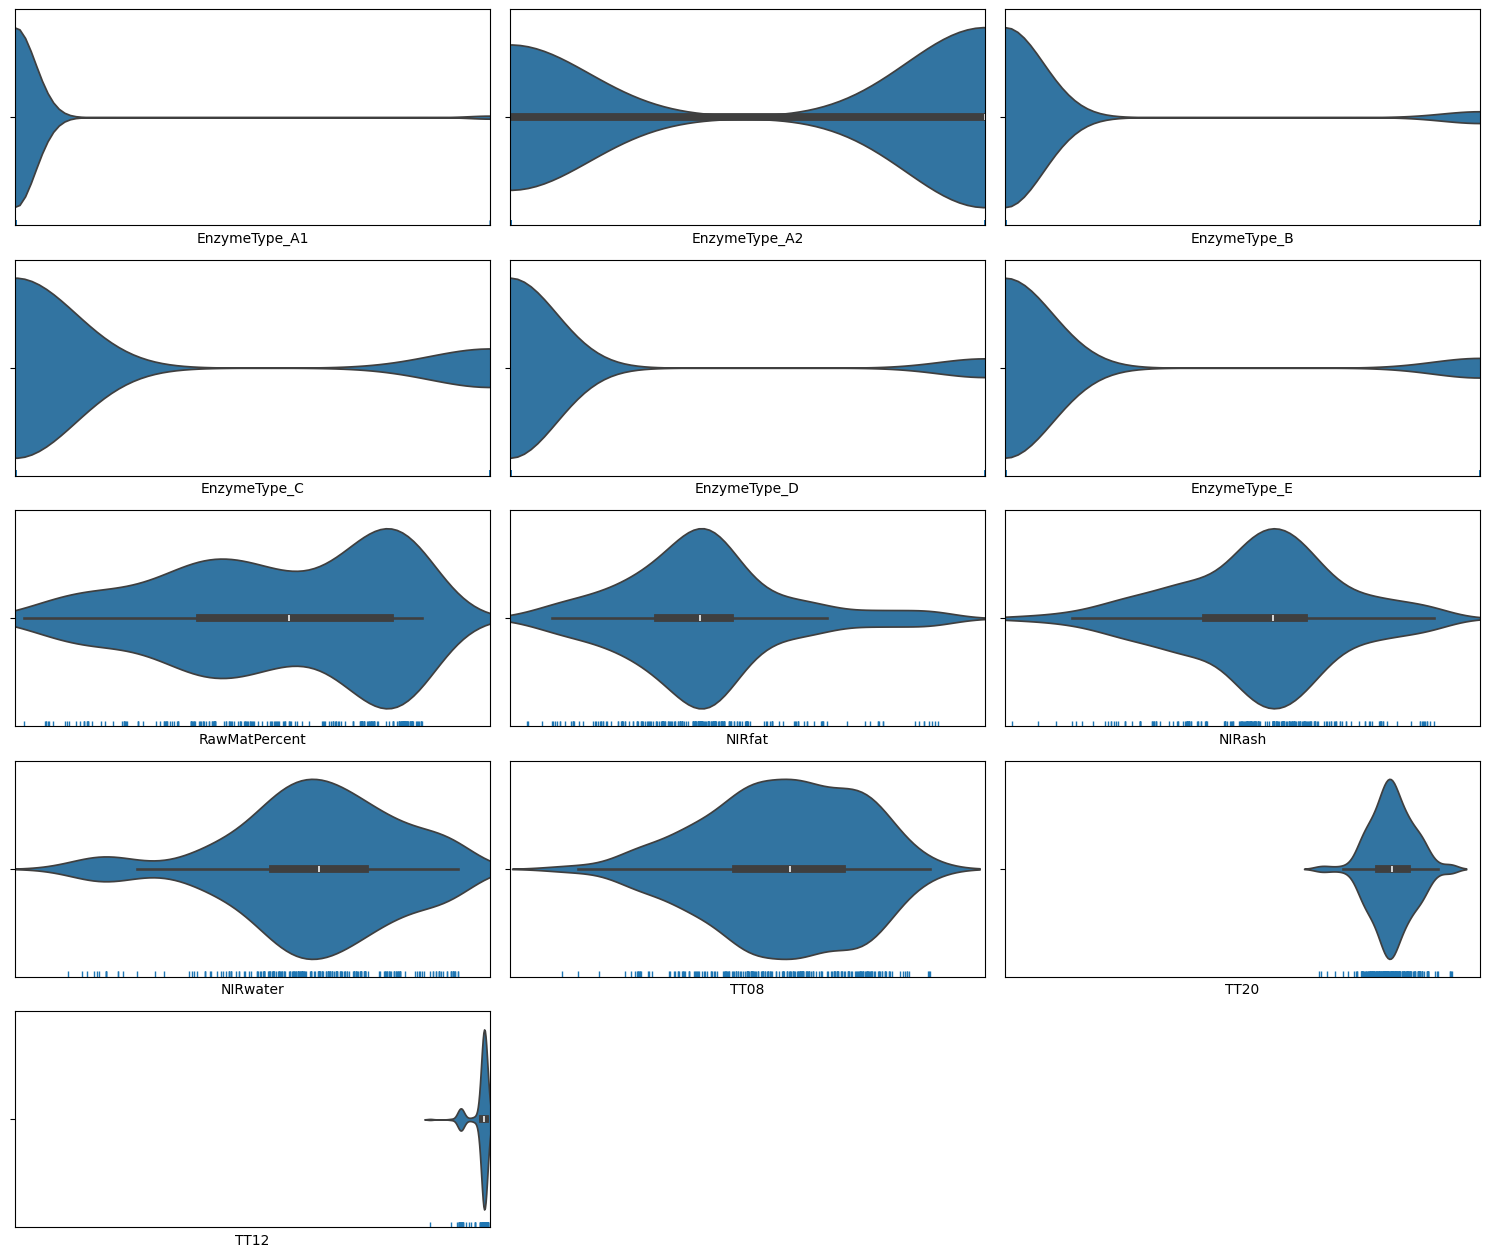

In [ ]:
# Violin plot av mulig ekstrem data av CBLOF
plot_violin_grid(mulige_ekstrem_lof_terskel_umarkert, min_max_dict, fig_size=(15, 20))

# Inpeksjon av gjenværende markert data

In [ ]:
data_markert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 448 entries, 2022-10-31 18:30:00 to 2023-06-13 23:00:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   448 non-null    int64  
 1   EnzymeType_A2   448 non-null    int64  
 2   EnzymeType_B    448 non-null    int64  
 3   EnzymeType_C    448 non-null    int64  
 4   EnzymeType_D    448 non-null    int64  
 5   EnzymeType_E    448 non-null    int64  
 6   RawMatPercent   448 non-null    float64
 7   NIRfat          448 non-null    float64
 8   NIRash          448 non-null    float64
 9   NIRwater        448 non-null    float64
 10  TT08            448 non-null    float64
 11  TT20            448 non-null    float64
 12  TT12            448 non-null    float64
 13  Collagen        83 non-null     float64
 14  Mw              448 non-null    float64
 15  SmallMolecules  448 non-null    float64
 16  BrixAdjusted    448 non-null    float64
dty

## Ekstremsverdi inspeksjon med LOF

1.1754407121411408


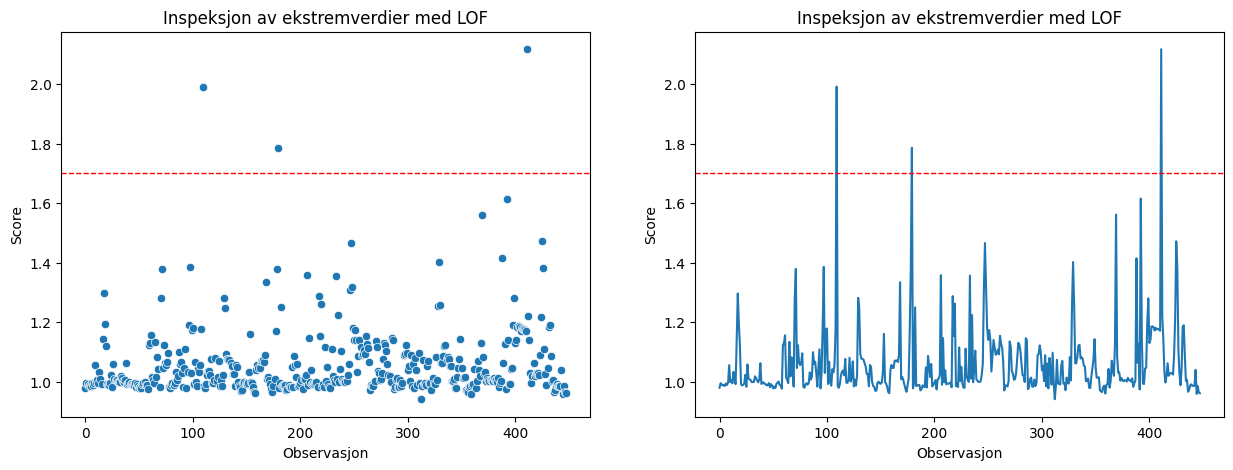

In [ ]:
# Ektremverdiinspeksjon med LOF på data
lof = LOF(n_neighbors=15)
lof.fit(X_markert)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_lof = lof.labels_
y_scores_lof = lof.decision_scores_
y_terskel_lof = lof.threshold_
print(y_terskel_lof)

#Setter terskel på score som anses som ekstrem observasjon
terskel_lof = 1.7

plot_ekstrem_score(y_scores_lof, terskel_lof, 'LOF', figsize=(15, 5))

Data etter behandling av ekstrem data med LOF

In [ ]:
# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_lof_indeks_markert = np.where(y_scores_lof > terskel_lof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_lof_terskel_markert = prediktor_markert.iloc[mulige_ekstrem_lof_indeks_markert]

# Utelukker ekstreme observasjoner fra data
behandlet_data_lof_markert = prediktor_markert.drop(prediktor_markert.index[mulige_ekstrem_lof_indeks_markert])

# Data etter inspeksjon med lof
print("Data etter lof:")
print(behandlet_data_lof_markert.info())

Data etter lof:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 445 entries, 2022-10-31 18:30:00 to 2023-06-13 23:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnzymeType_A1  445 non-null    int64  
 1   EnzymeType_A2  445 non-null    int64  
 2   EnzymeType_B   445 non-null    int64  
 3   EnzymeType_C   445 non-null    int64  
 4   EnzymeType_D   445 non-null    int64  
 5   EnzymeType_E   445 non-null    int64  
 6   RawMatPercent  445 non-null    float64
 7   NIRfat         445 non-null    float64
 8   NIRash         445 non-null    float64
 9   NIRwater       445 non-null    float64
 10  TT08           445 non-null    float64
 11  TT20           445 non-null    float64
 12  TT12           445 non-null    float64
dtypes: float64(7), int64(6)
memory usage: 48.7 KB
None


Violin plot

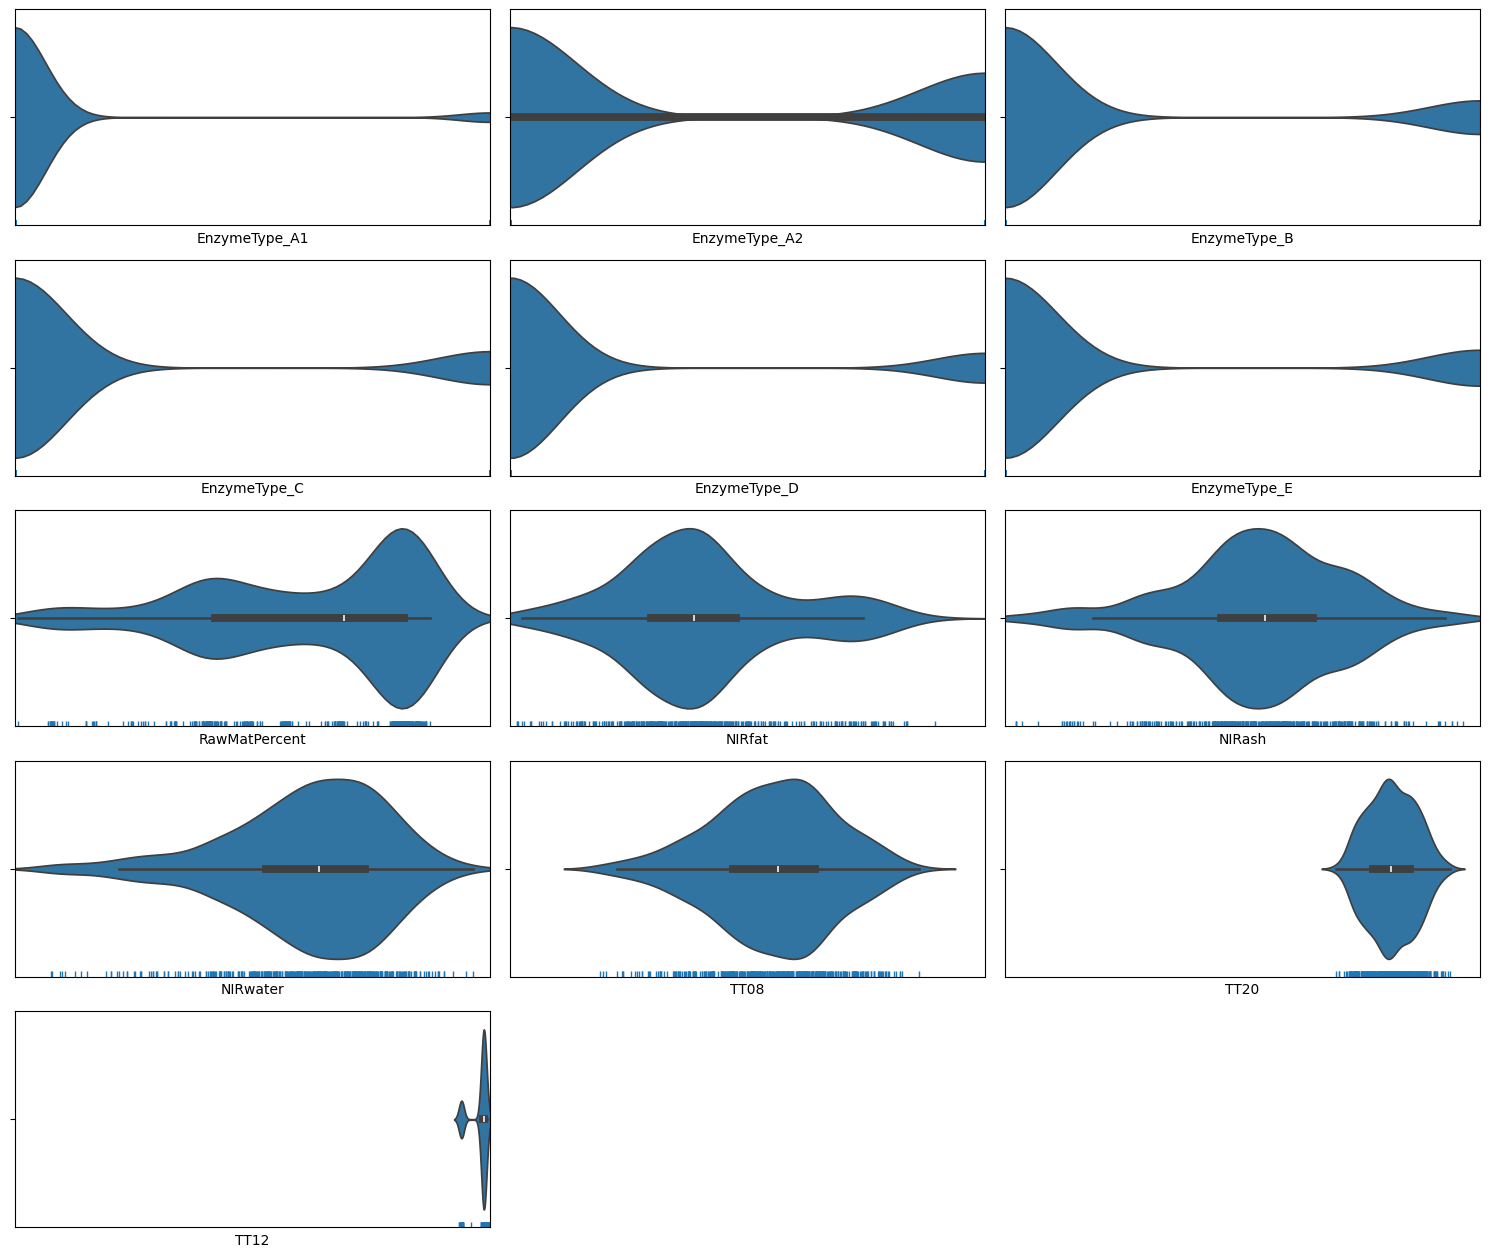

In [ ]:
# Violin plot av data etter behandling med CBLOF
plot_violin_grid(behandlet_data_lof_markert, min_max_dict, fig_size=(15, 20))

### Inspeksjon av ekstrem data

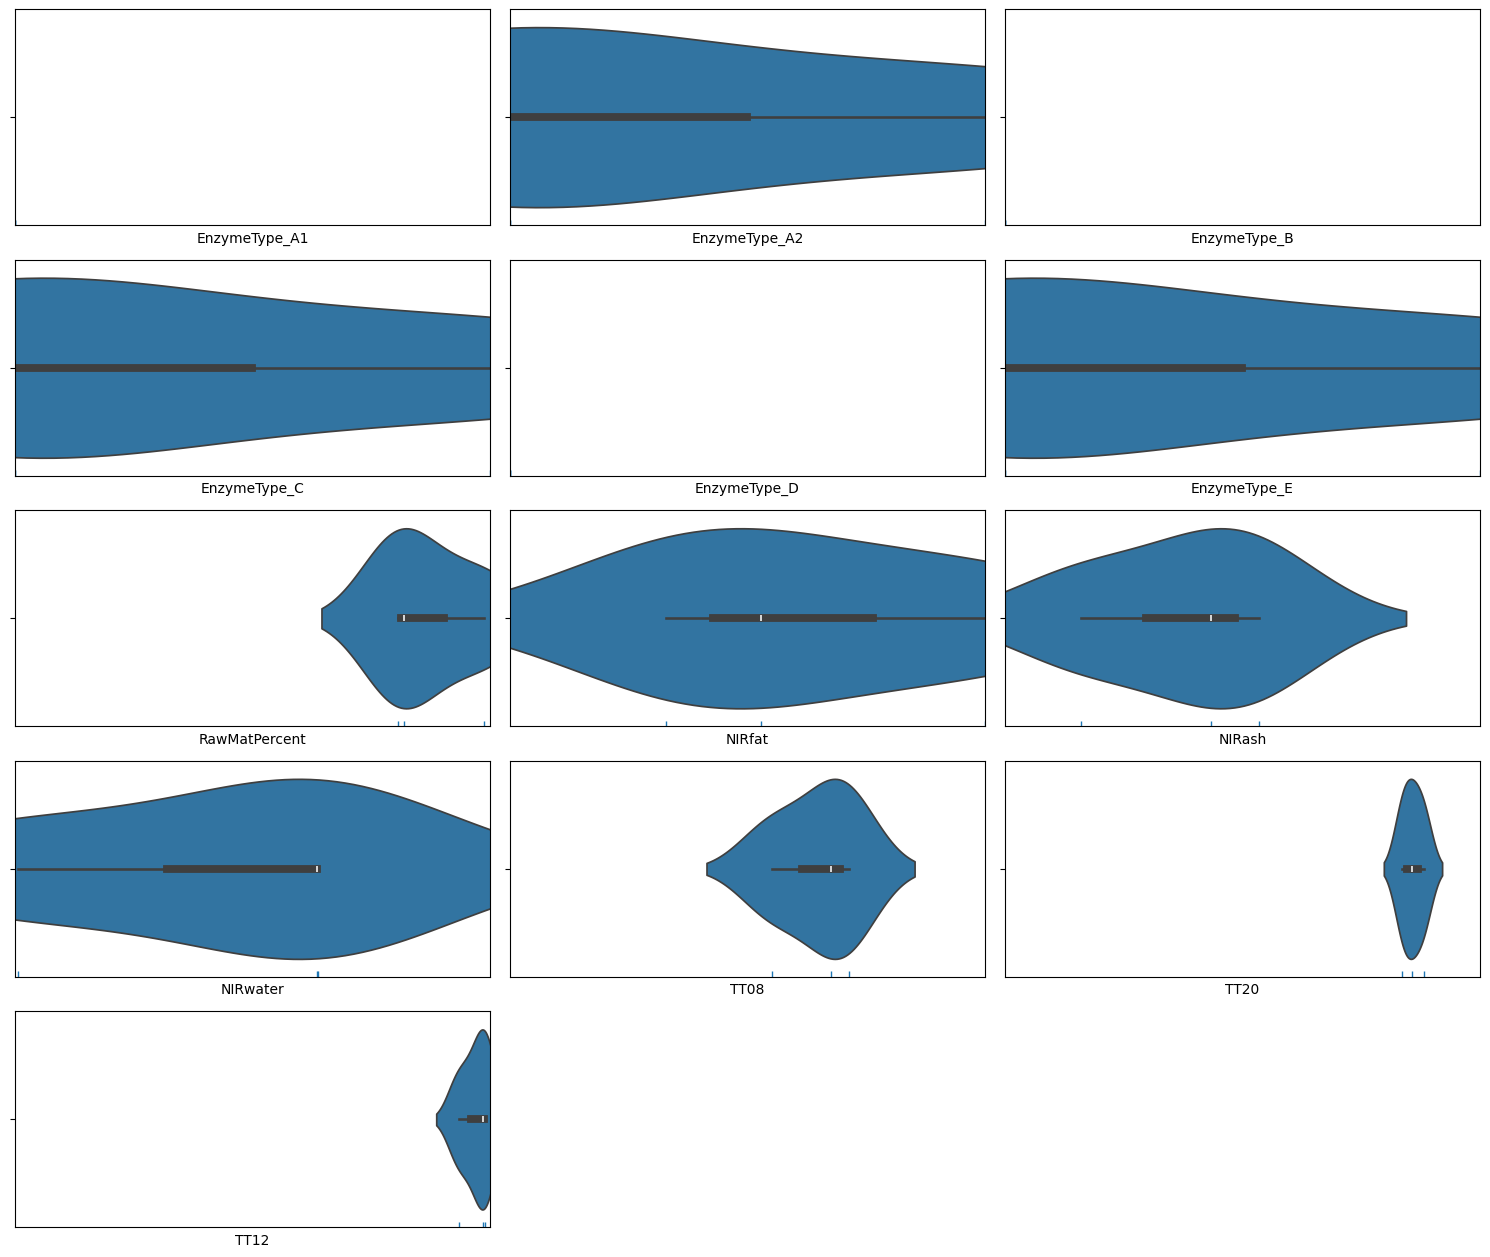

In [ ]:
# Violin plot av mulig ekstrem data av CBLOF
plot_violin_grid(mulige_ektrem_lof_terskel_markert, min_max_dict, fig_size=(15, 20))

In [ ]:
# Ekskluderer ektrem data fra original data med forklaringsvariabler
data_behandlet_umarkert = data_behandlet.drop(prediktor_umarkert.index[mulige_ekstrem_lof_indeks_umarkert], errors='ignore')

# Data før behandling
print("Data etter felles inspeksjon:")
print(data_behandlet.info())
# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(data_behandlet_umarkert.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28724 entries, 2022-10-31 17:37:00 to 2023-06-14 01:04:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28724 non-null  int64  
 1   EnzymeType_A2   28724 non-null  int64  
 2   EnzymeType_B    28724 non-null  int64  
 3   EnzymeType_C    28724 non-null  int64  
 4   EnzymeType_D    28724 non-null  int64  
 5   EnzymeType_E    28724 non-null  int64  
 6   RawMatPercent   28724 non-null  float64
 7   NIRfat          28724 non-null  float64
 8   NIRash          28724 non-null  float64
 9   NIRwater        28724 non-null  float64
 10  TT08            28724 non-null  float64
 11  TT20            28724 non-null  float64
 12  TT12            28724 non-null  float64
 13  Collagen        83 non-null     float64
 14  Mw              448 non-null    float64
 15  SmallMolecules  448 non-null    float64
 16  BrixAdjuste

In [ ]:
# Ekskluderer ektrem data fra original data med forklaringsvariabler
data_behandlet_fullstendig = data_behandlet_umarkert.drop(prediktor_markert.index[mulige_ekstrem_lof_indeks_markert], errors='ignore')

# Data før behandling
print("Data etter felles inspeksjon:")
print(data_behandlet_umarkert.info())
# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(data_behandlet_fullstendig.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28704 entries, 2022-10-31 17:37:00 to 2023-06-14 01:01:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28704 non-null  int64  
 1   EnzymeType_A2   28704 non-null  int64  
 2   EnzymeType_B    28704 non-null  int64  
 3   EnzymeType_C    28704 non-null  int64  
 4   EnzymeType_D    28704 non-null  int64  
 5   EnzymeType_E    28704 non-null  int64  
 6   RawMatPercent   28704 non-null  float64
 7   NIRfat          28704 non-null  float64
 8   NIRash          28704 non-null  float64
 9   NIRwater        28704 non-null  float64
 10  TT08            28704 non-null  float64
 11  TT20            28704 non-null  float64
 12  TT12            28704 non-null  float64
 13  Collagen        83 non-null     float64
 14  Mw              448 non-null    float64
 15  SmallMolecules  448 non-null    float64
 16  BrixAdjuste

# Undersøkelse av ekstrem data

Undersøker de ekstreme observasjonene

In [ ]:
# Filtrerer ut ekstrem data
ekstrem_data = behandlet_data.drop(data_behandlet_fullstendig.index)

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(ekstrem_data.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 435 entries, 2022-11-02 05:19:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   435 non-null    int64  
 1   EnzymeType_A2   435 non-null    int64  
 2   EnzymeType_B    435 non-null    int64  
 3   EnzymeType_C    435 non-null    int64  
 4   EnzymeType_D    435 non-null    int64  
 5   EnzymeType_E    435 non-null    int64  
 6   RawMatPercent   435 non-null    float64
 7   NIRfat          435 non-null    float64
 8   NIRash          435 non-null    float64
 9   NIRwater        435 non-null    float64
 10  TT08            435 non-null    float64
 11  TT20            435 non-null    float64
 12  TT12            435 non-null    float64
 13  Collagen        8 non-null      float64
 14  Mw              15 non-null     float64
 15  SmallMolecules  15 non-null     float64
 16  BrixAdjusted 

Violin plot

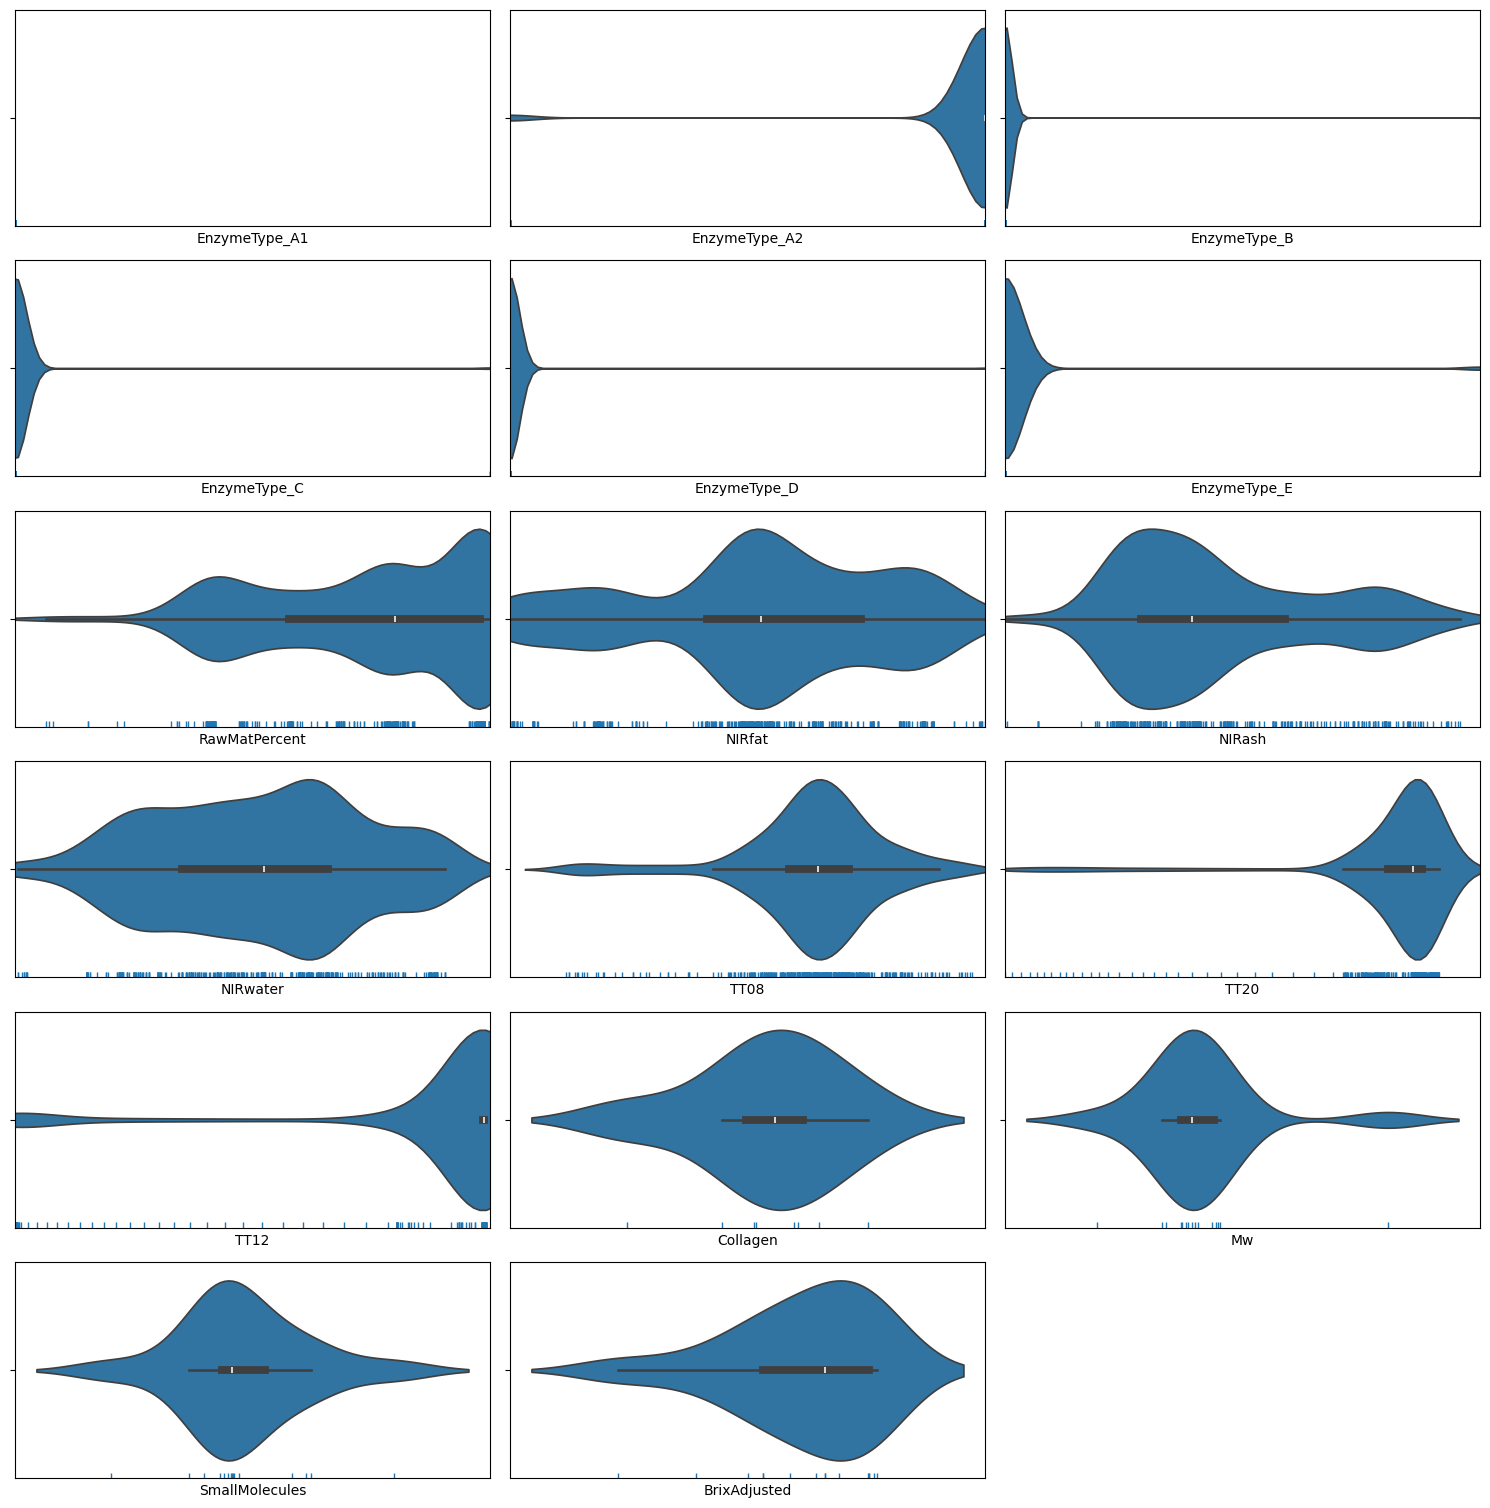

In [ ]:
# Violin plot av ekstrem data
plot_violin_grid(ekstrem_data, min_max_dict, fig_size=(15, 20))

Undersøker markert data som ikke blir inkludert

In [ ]:
# Filtrerer ut markert data fra ekstrem data filtrert
ekstrem_markert = ekstrem_data.dropna(subset=['Mw'])
ekstrem_markert

,EnzymeType_A1,EnzymeType_A2,EnzymeType_B,EnzymeType_C,EnzymeType_D,EnzymeType_E,RawMatPercent,NIRfat,NIRash,NIRwater,TT08,TT20,TT12,Collagen,Mw,SmallMolecules,BrixAdjusted
sampleID,,,,,,,,,,,,,,,,,
2022-11-04 11:08:00,0,1,0,0,0,0,40.084567,19.478791,4.574664,61.145028,60.42795,60.327900,94.005570,27.12,6398.646698,9.377519,0.114757
2022-11-04 13:11:00,0,1,0,0,0,0,40.410449,14.381851,5.242790,62.643827,60.91080,60.377660,94.099240,20.49,5327.668564,10.599001,0.106408
2022-11-04 13:48:00,0,1,0,0,0,0,40.397595,17.153726,4.667164,62.542971,60.63954,60.275790,94.048610,NaN,5804.847704,10.276916,0.106442
2022-11-04 15:03:00,0,1,0,0,0,0,40.414170,12.437946,6.668482,63.043080,60.31944,60.131275,94.129630,12.26,3858.004543,12.021483,0.101450
2022-11-09 04:40:00,0,0,0,1,0,0,37.560811,24.947005,3.548948,59.103614,60.78603,60.083900,93.916960,33.20,10044.742371,7.191238,0.085195
2022-12-01 12:50:00,0,1,0,0,0,0,34.801911,17.842532,5.381879,62.006226,60.52561,59.332900,86.508825,23.29,5235.432713,9.264557,0.060342
2022-12-13 09:45:00,0,1,0,0,0,0,31.639288,20.073750,4.505190,61.406672,61.58897,59.520060,94.149885,NaN,6433.265780,8.521806,0.123264
2022-12-13 09:55:00,0,1,0,0,0,0,31.774826,21.250747,3.851002,60.754326,61.38824,59.520060,93.889110,28.98,6298.379432,8.787621,0.125886
2022-12-13 10:00:00,0,1,0,0,0,0,32.207659,21.250747,3.851002,60.754326,60.81315,59.306835,93.876450,26.81,5761.500503,9.044750,0.130404


# Lagring av data behandlet for ekstreme verdier som csv

In [ ]:
data_behandlet_fullstendig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28701 entries, 2022-10-31 17:37:00 to 2023-06-14 01:01:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28701 non-null  int64  
 1   EnzymeType_A2   28701 non-null  int64  
 2   EnzymeType_B    28701 non-null  int64  
 3   EnzymeType_C    28701 non-null  int64  
 4   EnzymeType_D    28701 non-null  int64  
 5   EnzymeType_E    28701 non-null  int64  
 6   RawMatPercent   28701 non-null  float64
 7   NIRfat          28701 non-null  float64
 8   NIRash          28701 non-null  float64
 9   NIRwater        28701 non-null  float64
 10  TT08            28701 non-null  float64
 11  TT20            28701 non-null  float64
 12  TT12            28701 non-null  float64
 13  Collagen        81 non-null     float64
 14  Mw              445 non-null    float64
 15  SmallMolecules  445 non-null    float64
 16  BrixAdjusted    445 non-null    float64
d

In [ ]:
data_behandlet_fullstendig.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/ekstremverdi_data_behandlet_bioco_data.csv')